# PRE-PROCESAMIENTO

Pandas requiere una version '1.2.0' o más recierte de xlrd

In [1]:
!pip install --upgrade xlrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 841 kB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


Mapa con las estaciones y la cantidad de contaminantes que cuentan. Despues de imputar calcular el indice y compararlo con el viejo. Sacar informacion del modelo que usan para predecir.

## Importaciones de librerías

Utilizaremos pandas y numpy para la manipulación, procesamiento y manejo de los datos. Matplotlit y seaborn para la parte gráfica del analisis explotorio de datos. De igual manera se usará tensorflow para el modelo GAIN para la imputación de datos. Por otra parte se usarán demas librerias nativas como glob, re y random.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re
import os
import tensorflow.compat.v1 as tf
from tqdm import tqdm
import random


plt.rcParams["figure.figsize"] = [13, 7]

## Lectura de los datasets

Los datasets o bases de datos se encuentran en el Google Drive 'Contaminación del aire': https://drive.google.com/drive/folders/1Wg9FAZTBNzDf2MHN8bj7AO97chDJWy0e especificamente en la ruta: /Contaminación del aire/Recursos/Datasets/

Cada archivo de bases de datos se encuentra en formato xls (Excel) y tiene la siguiente estructura de nombre:

2018PM10.xls

Donde Los primeros cuatro numeros corresponden al año que corresponden las mediciones y las ultimas letras es la abreviatura del parametro o contaminante medido.

Cada base de datos pertenece a una de las 6 redes de monitoreo del aire en la Ciudad de México, las cuales son:

1. Red Automatica de Monitoreo Atmosférico(RAMA)
2. Red de Meteorología
3. Red Manual de Monitoreo Atmorférico
4. Red de Depósito Atmosférico
5. Red de Radiación Solar
6. Red de Presión Atmosférica



Nuestro trabajo abarcará el uso de los datos de monitoreo de los parametros correspondientes a las redes: RAMA, Red de Radiación Solar y de Presión Atmosférica, a partir del año 2017 hasta el año 2021.

El repositorio completo de datos para otros años se puede encontrar en la siguiente página: http://www.aire.cdmx.gob.mx/default.php?opc=%27aKBhnmM=%27 






### Red Automática de Monitoreo Atmosférico (RAMA)

Contaminantes que se miden en RAMA

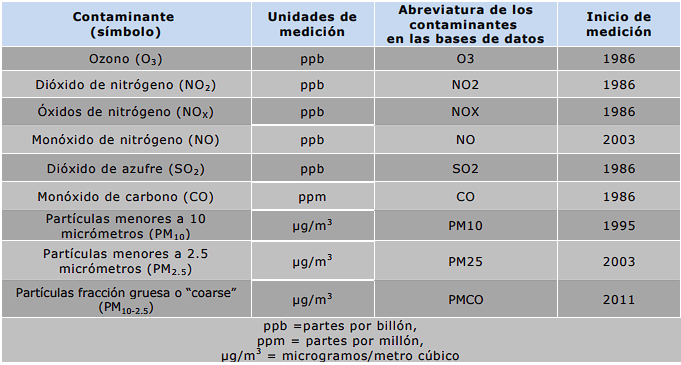


### Red de Meteorología

Parametros que se miden en la Red de Meteorología

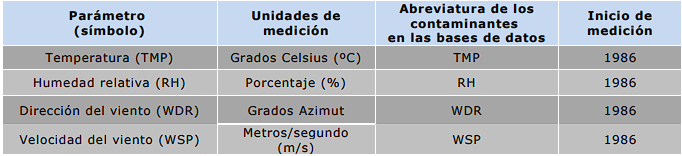

### Red de Radiación Solar (RADIACIÓN)

Parametros que se miden en RADIACIÓN

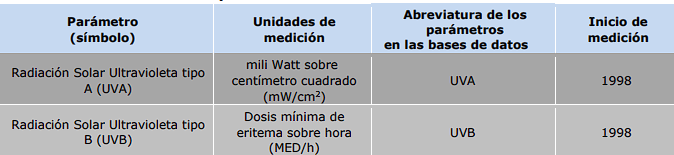

Red de Presión Atmosférica

Parametros que se miden en la Red de Presión Atmosférica

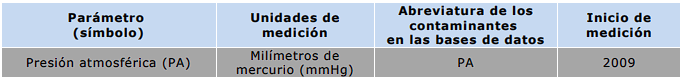

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Leemos las bases de datos

In [4]:
all_files = []

for i in range(17, 22):
  path = fr'/content/drive/MyDrive/Contaminación del aire/Recursos/Datasets/1- Red Automatica de Monitoreo Atmosférico(RAMA)/Datasets/20{i}'
  filesOnFolder = glob.glob(path + "/*.xls")
  all_files.extend(filesOnFolder)

for i in range(17, 22):
  path = fr'/content/drive/MyDrive/Contaminación del aire/Recursos/Datasets/2- Red de Meteorología y Radiación Solar/Datasets/20{i}'
  filesOnFolder = glob.glob(path + "/*.xls")
  all_files.extend(filesOnFolder)

for i in range(17, 22):
  path = fr'/content/drive/MyDrive/Contaminación del aire/Recursos/Datasets/5- Red Automática de Monitoreo Atmosférico (RADIACIÓN)/Datasets/20{i}'
  filesOnFolder = glob.glob(path + "/*.xls")
  all_files.extend(filesOnFolder)

for i in range(17, 22):
  path = fr'/content/drive/MyDrive/Contaminación del aire/Recursos/Datasets/6- Red Automática de Monitoreo Atmosférico(PRESIÓN ATMOSFÉRICA)/Datasets/20{i}'
  filesOnFolder = glob.glob(path + "/*.xls")
  all_files.extend(filesOnFolder)


In [5]:
tempDf = pd.read_excel(all_files[0])

In [6]:
all_files[0]

'/content/drive/MyDrive/Contaminación del aire/Recursos/Datasets/1- Red Automatica de Monitoreo Atmosférico(RAMA)/Datasets/2017/2017NO.xls'

Un archivo de base de datos se encuentra estructurado de la siguiente manera:

In [7]:
tempDf.head()

,FECHA,HORA,ACO,AJM,ATI,BJU,CAM,CCA,CHO,COY,...,SAG,SFE,SJA,TAH,TLA,TLI,UAX,UIZ,VIF,XAL
0,2017-01-01,1,-99,0,-99,-99,1,1,-99,10,...,22,1,20,32,38,25,4,7,-99,17
1,2017-01-01,2,-99,0,-99,-99,3,1,-99,13,...,29,0,61,25,28,24,8,4,-99,59
2,2017-01-01,3,-99,0,-99,-99,2,5,-99,21,...,15,0,31,8,24,11,9,14,-99,56
3,2017-01-01,4,14,0,-99,-99,8,12,-99,20,...,33,0,65,8,24,43,9,8,-99,92
4,2017-01-01,5,7,0,-99,-99,41,15,-99,18,...,11,1,109,12,23,48,18,9,-99,82


Donde:
1. La columna FECHA indica la fecha de medición en formato: AAAA-MM-DD.
2. La columna HORA indica la hora del día de la medición.

Y las siguientes columnas indican la estación de monitoreo en donde se realizó la medición

Si la medición es -99 se toma como dato NULO.


### Manejo y limpieza de datos

Ahora nuestro objetivo es cambiar la estructura de nuestra bases de datos. En la base de datos original, cada archivo contiene las mediciones de un parametro para cada estacion en un año determinado, en este punto, nuestro objetivo es generar un archivo para cada estación, en donde cada columna contenga las mediciones de los parametros o contaminantes medidos a lo largo del 2017 al 2021.

Para esto, comenzaremos obteniendo todas las columnas de las bases de datos. De esta manera tendremos una lista con los nombres de todas las estaciones de monitoreo más 'FECHA' y 'HORA'

In [8]:
columns = []

for file in all_files:
  tempDf = pd.read_excel(file)
  for col in tempDf.columns:
    if not col in columns:
      columns.append(col)

myColumns = ['FECHA', 'HORA']
myDict = {}
estaciones = columns[2:]

Una vez tenemos una lista con los nombres de las estaciones comenzaremos iterando entre todos los archivos originales, usamos una expresión regular en el nombre del archivo para obtener la abreviatura del parametro del archivo que estamos leyendo.

In [9]:
for file in all_files:
  tempDf = pd.read_excel(file, parse_dates=True)
  x = re.search(r"[A-Z]+\d*",os.path.basename(file))
  for col in tempDf.columns:
    tempSeries = None
    theSeries = None
    index = None
    if col in estaciones:
      if col in myDict.keys():
        tempSeries = tempDf[col];
        tempSeries.name = x.group()
        for i, item in enumerate(myDict[col]):
          if (item.name == tempSeries.name):
            index = i
            break
        if index == None:
            myDict[col].append(tempSeries)
        else:
          # myDict[col].append(tempSeries)
          theList = [myDict[col][index], tempSeries]
          theNew = pd.concat(theList, ignore_index=True)
          myDict[col][index] = theNew
      else:
        theSeries = tempDf[col]
        theSeries.name = x.group()
        tempSeries = [tempDf[col]];
        myDict.update({col: tempSeries})

Una vez hecho esto, tendremos un diccionario en donde las llaves seran las estaciones que contendran una lista de todos los parametros o contaminantes medidos en esa estación.

In [10]:
myDict['ACO'][0]

0       -99
1       -99
2       -99
3        14
4         7
         ..
43819     2
43820     3
43821    12
43822    23
43823    18
Name: NO, Length: 43824, dtype: int64

In [11]:
myDict.keys()

dict_keys(['ACO', 'AJM', 'ATI', 'BJU', 'CAM', 'CCA', 'CHO', 'COY', 'CUA', 'CUT', 'FAC', 'HGM', 'INN', 'IZT', 'LLA', 'LPR', 'MER', 'MGH', 'MON', 'MPA', 'NEZ', 'PED', 'SAG', 'SFE', 'SJA', 'TAH', 'TLA', 'TLI', 'UAX', 'UIZ', 'VIF', 'XAL', 'AJU', 'GAM', 'FAR', 'SAC', 'LAA', 'Fecha', 'Hora'])

In [12]:
del myDict['Fecha']

In [13]:
del myDict['Hora']

### Índice de datetime

Para manejar de mejor manera nuestros dataframes de series de tiempo vamos a convertir las columnas FECHA y HORA de nuestros dataframes a una única columna en formato datetime.

Para esto, debido a que todos y cada uno de los archivos cuentan con el mismo rango de fechas, para obtener nuestro indice de datetime, podemos tomar un archivo cualquiera de cada año y obtenemos las columnas "FECHA" y "HORA", esto nos dara las fechas y horas del año que estemos tomando, ahora, para unirlas, sumamos ambas columnas que nos da como resultado una única columna en formato datetime.




In [14]:
file2017 = r'/content/drive/MyDrive/Contaminación del aire/Recursos/Datasets/1- Red Automatica de Monitoreo Atmosférico(RAMA)/Datasets/2017/2017NOX.xls'
file2018 = r'/content/drive/MyDrive/Contaminación del aire/Recursos/Datasets/1- Red Automatica de Monitoreo Atmosférico(RAMA)/Datasets/2018/2018CO.xls'
file2019 = r'/content/drive/MyDrive/Contaminación del aire/Recursos/Datasets/1- Red Automatica de Monitoreo Atmosférico(RAMA)/Datasets/2019/2019SO2.xls'
file2020 = r'/content/drive/MyDrive/Contaminación del aire/Recursos/Datasets/1- Red Automatica de Monitoreo Atmosférico(RAMA)/Datasets/2020/2020NO.xls'
file2021 = r'/content/drive/MyDrive/Contaminación del aire/Recursos/Datasets/1- Red Automatica de Monitoreo Atmosférico(RAMA)/Datasets/2021/2021SO2.xls'

df2017 = pd.read_excel(file2017)
df2018 = pd.read_excel(file2018)
df2019 = pd.read_excel(file2019)
df2020 = pd.read_excel(file2020)
df2021 = pd.read_excel(file2021)

horas2017 = pd.to_datetime(df2017['FECHA']) + pd.to_timedelta(df2017['HORA'], unit='h')
horas2018 = pd.to_datetime(df2018['FECHA']) + pd.to_timedelta(df2018['HORA'], unit='h')
horas2019 = pd.to_datetime(df2019['FECHA']) + pd.to_timedelta(df2019['HORA'], unit='h')
horas2020 = pd.to_datetime(df2020['FECHA']) + pd.to_timedelta(df2020['HORA'], unit='h')
horas2021 = pd.to_datetime(df2021['FECHA']) + pd.to_timedelta(df2021['HORA'], unit='h')

Posteriormente, concatenamos las columnas de fecha por año en una sola para anexarla a cada uno de nuestros dataframes.

In [15]:
listOfHours = [horas2017, horas2018, horas2019, horas2020, horas2021]
dfOfHours = pd.concat(listOfHours, ignore_index=True)

Creamos nuestros dataframes con el diccionario que obtuvimos anteriormente. El nombre del dataframe seran las llaves de nuestro diccionario y cada columna seran los valores de cada llave. Además insertamos la columna de FECHA con el indice de datetime que sacamos anteriormente. Por último reemplazamos los -99 de nuestro conjunto de datos por NaN. Todos los dataframes los almacenaremos en una lista.

In [17]:
dfs = []
newDfs = []

for key, values in myDict.items():
  myDf = None
  myDf = pd.concat(values, axis=1, keys=[s.name for s in values])
  myDf.name = key
  dfs.append(myDf)
  myDf.insert(0, 'FECHA', dfOfHours)
  datetime_series = pd.to_datetime(myDf['FECHA'])

# create datetime index passing the datetime series
  datetime_index = pd.DatetimeIndex(datetime_series.values)
  df2=myDf.set_index(datetime_index)
  df2.drop('FECHA',axis=1,inplace=True)
  df2.replace(-99,np.NaN, inplace = True)
  df2.name = myDf.name
  newDfs.append(df2)


In [18]:
len(newDfs)

37

Para finalizar, algunas columnas de nuestra base de datos están llenas en su totalidad de -99 en todos los años por lo que las eliminamos con el siguiente código:

In [19]:
for df in newDfs:
  for column in df:
    if df[column].isnull().all():
      df.drop(column, axis=1, inplace=True)

Todas las estaciones:

In [20]:
for df in newDfs:
  print(df.name)

ACO
AJM
ATI
BJU
CAM
CCA
CHO
COY
CUA
CUT
FAC
HGM
INN
IZT
LLA
LPR
MER
MGH
MON
MPA
NEZ
PED
SAG
SFE
SJA
TAH
TLA
TLI
UAX
UIZ
VIF
XAL
AJU
GAM
FAR
SAC
LAA


Cuales variables y contaminantes hay registrados entre todas las estaciones

In [21]:
columns = []
for df in newDfs:
  for column in df:
    if column not in columns:
      columns.append(column)

In [22]:
len(columns)

16

In [23]:
columns

['NO',
 'SO2',
 'O3',
 'NO2',
 'PM10',
 'NOX',
 'CO',
 'WSP',
 'TMP',
 'WDR',
 'RH',
 'PMCO',
 'PM25',
 'PA',
 'UVB',
 'UVA']

In [24]:
columnsDic = {
    'NO': 0,
 'SO2': 0,
 'O3': 0,
 'NO2': 0,
 'PM10': 0,
 'NOX': 0,
 'CO': 0,
 'WSP': 0,
 'TMP': 0,
 'WDR': 0,
 'RH': 0,
 'PMCO': 0,
 'PM25': 0,
 'PA': 0,
 'UVB': 0,
 'UVA': 0,
}

In [25]:
for df in newDfs:
  for column in df:
    columnsDic[column] = columnsDic[column] + 1 

In [26]:
columnsDic

{'NO': 29,
 'SO2': 33,
 'O3': 36,
 'NO2': 34,
 'PM10': 26,
 'NOX': 30,
 'CO': 32,
 'WSP': 28,
 'TMP': 28,
 'WDR': 28,
 'RH': 28,
 'PMCO': 15,
 'PM25': 23,
 'PA': 10,
 'UVB': 11,
 'UVA': 11}

ACO
11
NO
57.730923694779115
SO2
55.06115370573202
O3
58.860441767068274
NO2
57.728641840087626
PM10
69.3592552026287
NOX
57.73320554947061
CO
57.08515881708653
WSP
88.8189120116831
TMP
89.39850310332238
WDR
88.8189120116831
RH
74.8653705732019


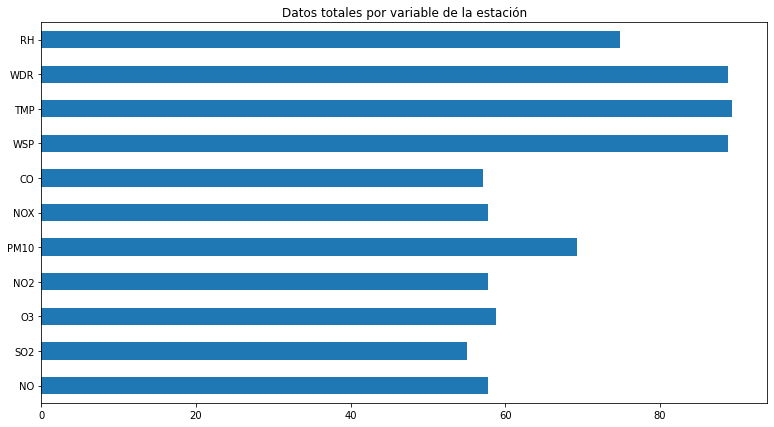

AJM
14
NO
64.31635633442862
PMCO
54.96303395399781
SO2
64.21367287331142
PM25
54.96303395399781
O3
58.974534501642935
NO2
64.31635633442862
PM10
54.96303395399781
NOX
64.31635633442862
CO
64.81151880248265
WSP
81.46677619569186
TMP
65.96385542168674
WDR
81.46677619569186
RH
67.41283315078496
PA
87.92670682730923


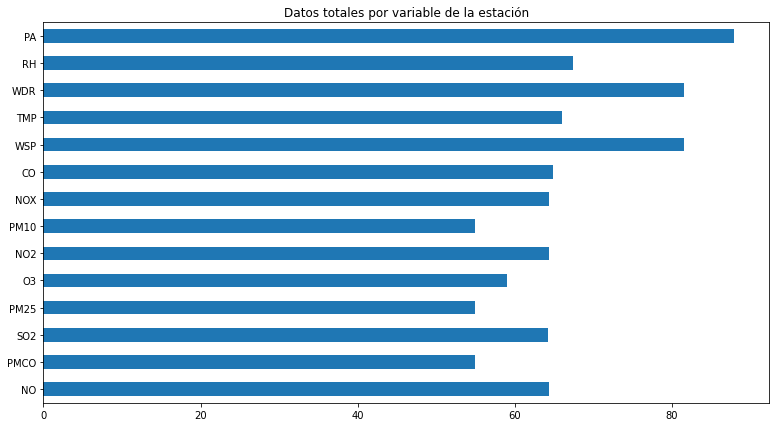

ATI
7
NO
65.01460387002555
SO2
81.68355239138371
O3
87.22617743702081
NO2
65.01460387002555
PM10
81.24315443592552
NOX
65.01460387002555
CO
79.72115735669952


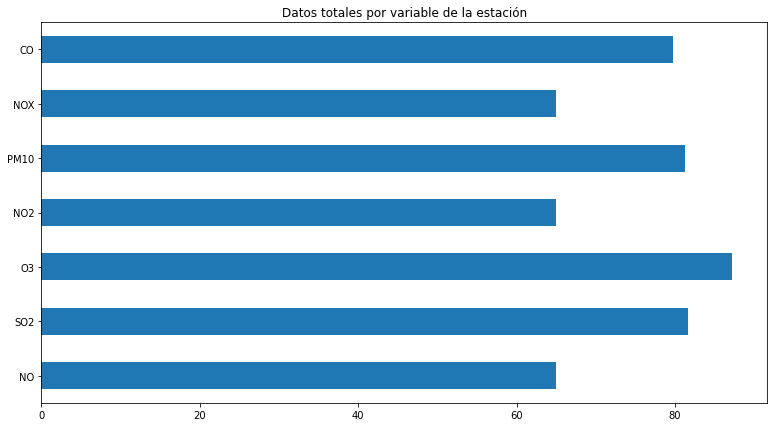

BJU
11
PMCO
83.27400511135451
SO2
83.27400511135451
PM25
83.27400511135451
O3
90.21312522818548
NO2
51.26186564439576
PM10
83.27400511135451
CO
89.72252646951442
WSP
97.11801752464403
TMP
91.64612997444323
WDR
97.11801752464403
RH
97.91210295728368


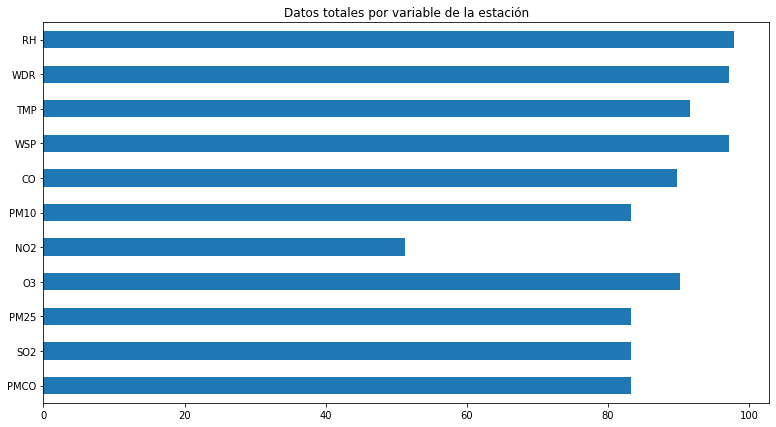

CAM
9
NO
76.63608981380065
PMCO
67.228002920774
SO2
73.08780576852865
PM25
67.228002920774
O3
78.37714494341
NO2
76.63608981380065
PM10
67.228002920774
NOX
76.63608981380065
CO
74.2903431909456


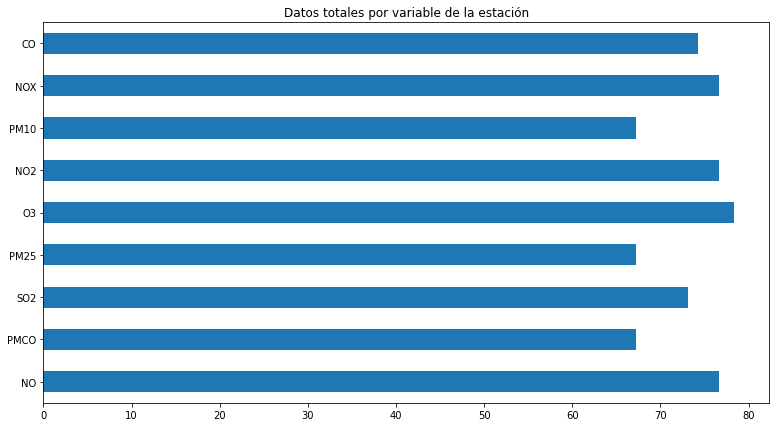

CCA
7
NO
86.74470609711574
SO2
91.29928806133626
PM25
85.2386820007302
O3
89.05166119021541
NO2
86.74470609711574
NOX
86.74470609711574
CO
84.54043446513326


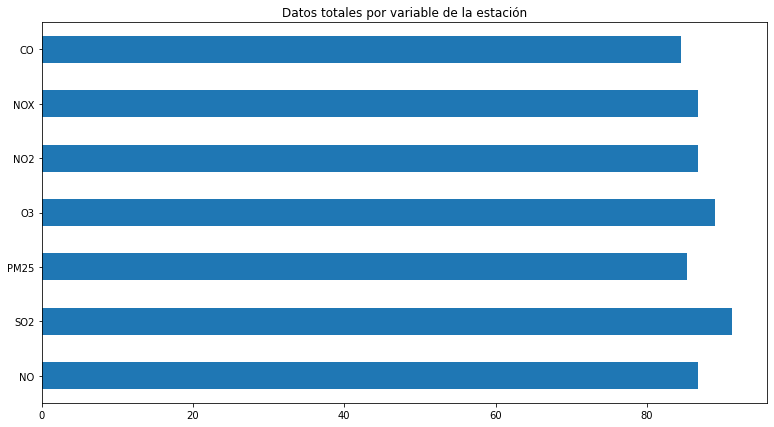

CHO
13
NO
29.874041621029573
SO2
46.85104052573932
O3
51.213946695874405
NO2
29.874041621029573
PM10
45.65078495801387
NOX
29.874041621029573
CO
46.342186929536325
WSP
84.1593647316539
TMP
79.99269806498722
WDR
84.1593647316539
RH
79.98813435560423
UVB
54.16894852135816
UVA
54.059419496166484


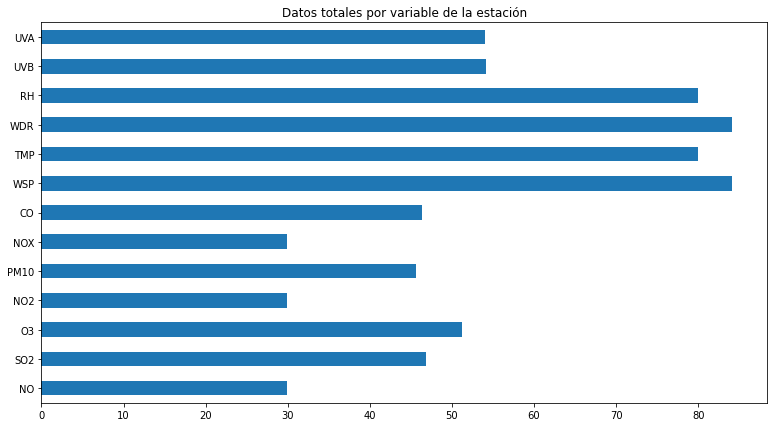

COY
5
NO
12.673420956553487
PM25
13.310058415480102
O3
13.234757210660826
NO2
12.673420956553487
NOX
12.673420956553487
se elimina:  Empty DataFrame
Columns: []
Index: [2017-01-01 01:00:00, 2017-01-01 02:00:00, 2017-01-01 03:00:00, 2017-01-01 04:00:00, 2017-01-01 05:00:00, 2017-01-01 06:00:00, 2017-01-01 07:00:00, 2017-01-01 08:00:00, 2017-01-01 09:00:00, 2017-01-01 10:00:00, 2017-01-01 11:00:00, 2017-01-01 12:00:00, 2017-01-01 13:00:00, 2017-01-01 14:00:00, 2017-01-01 15:00:00, 2017-01-01 16:00:00, 2017-01-01 17:00:00, 2017-01-01 18:00:00, 2017-01-01 19:00:00, 2017-01-01 20:00:00, 2017-01-01 21:00:00, 2017-01-01 22:00:00, 2017-01-01 23:00:00, 2017-01-02 00:00:00, 2017-01-02 01:00:00, 2017-01-02 02:00:00, 2017-01-02 03:00:00, 2017-01-02 04:00:00, 2017-01-02 05:00:00, 2017-01-02 06:00:00, 2017-01-02 07:00:00, 2017-01-02 08:00:00, 2017-01-02 09:00:00, 2017-01-02 10:00:00, 2017-01-02 11:00:00, 2017-01-02 12:00:00, 2017-01-02 13:00:00, 2017-01-02 14:00:00, 2017-01-02 15:00:00, 2017-01-02 1

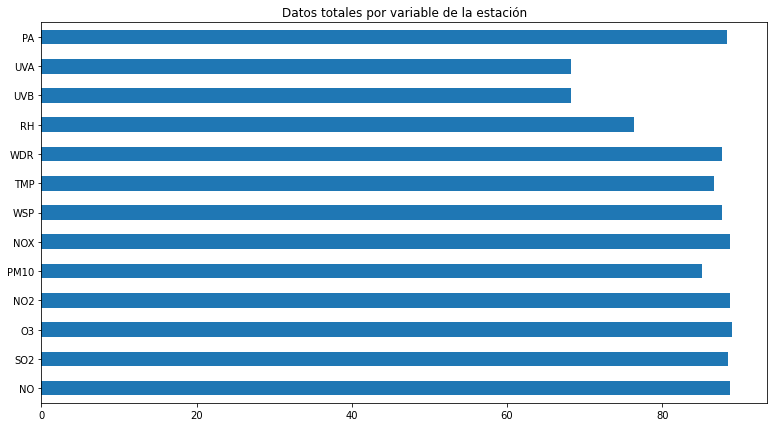

FAC
13
NO
89.44642205184374
SO2
85.72928075940123
O3
89.56736035049288
NO2
89.44642205184374
PM10
83.07092004381161
NOX
89.44642205184374
CO
89.11555312157722
WSP
96.69815626140927
TMP
91.45901788974078
WDR
96.69815626140927
RH
91.45901788974078
UVB
78.40452719970793
UVA
78.3451989777291


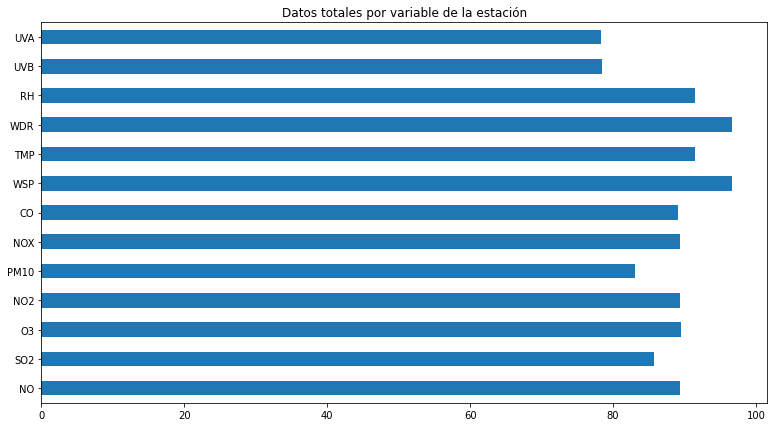

HGM
14
NO
63.56106243154436
PMCO
49.3587988316904
SO2
63.26670317634173
PM25
49.3587988316904
O3
63.86683096020445
NO2
63.56106243154436
PM10
49.3587988316904
NOX
63.56106243154436
CO
63.57703541438481
WSP
82.73092369477912
TMP
82.73320554947061
WDR
82.73092369477912
RH
82.74689667761957
PA
82.78797006206645


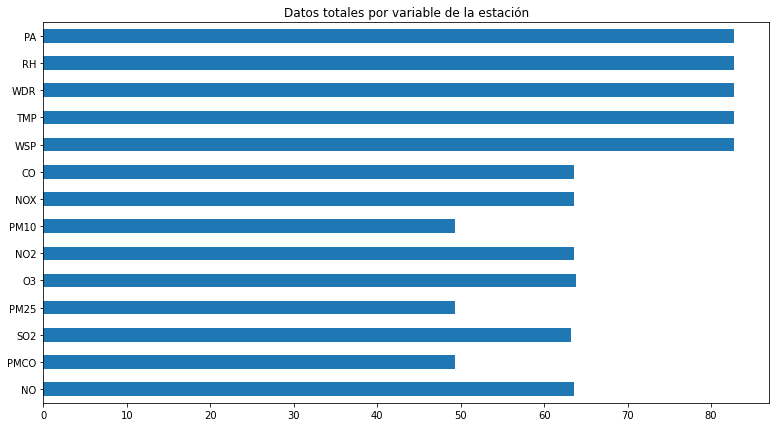

INN
11
PMCO
63.05905439941584
SO2
85.47599488864549
PM25
63.05905439941584
O3
83.80111354508945
PM10
63.05905439941584
CO
83.3766885724717
WSP
90.72426067907996
TMP
50.707374954362905
WDR
90.77217962760132
RH
84.62714494341
PA
88.73904709748084


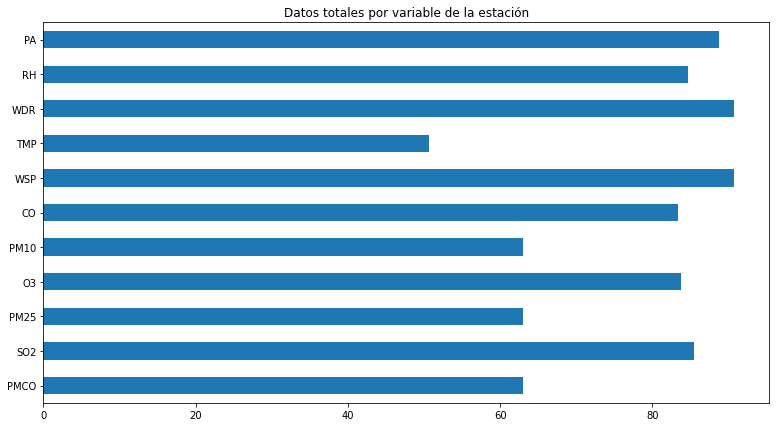

IZT
7
NO
71.87157721796277
SO2
74.9680540343191
O3
74.28121577217962
NO2
71.87157721796277
PM10
75.47918948521358
NOX
71.87157721796277
CO
71.81909456005842


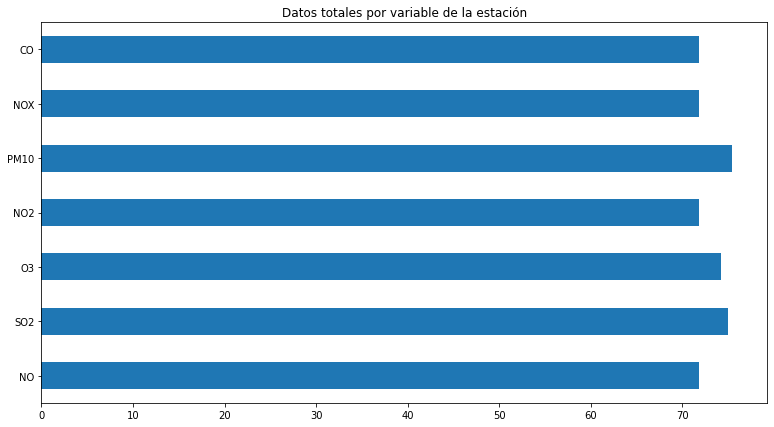

LLA
6
NO
39.5947426067908
SO2
66.6872033588901
O3
76.0815991237678
NO2
39.5947426067908
NOX
39.5947426067908
CO
59.775465498357065


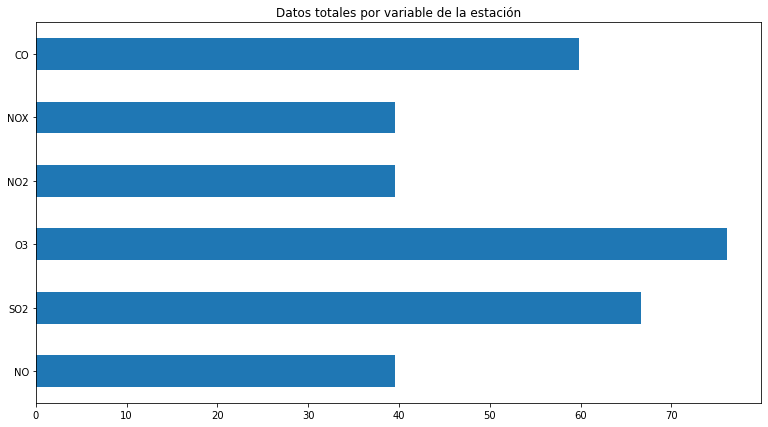

LPR
3
SO2
80.54718875502007
O3
84.23466593647316
CO
82.89065352318364


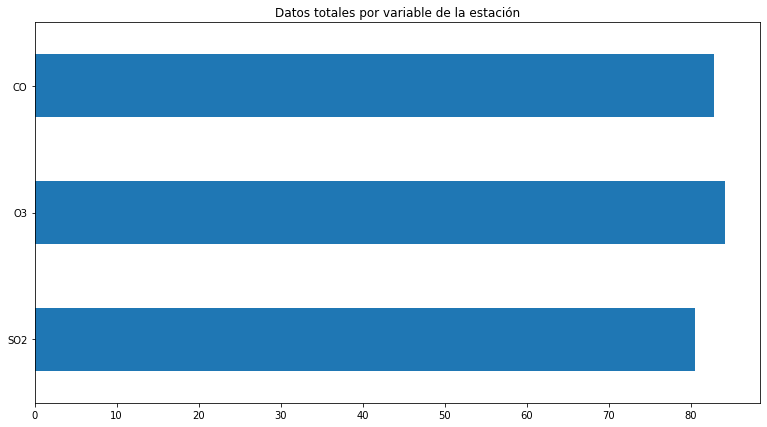

MER
16
NO
91.74196787148594
PMCO
82.15133260313983
SO2
91.894852135816
PM25
82.15133260313983
O3
93.38262139466958
NO2
91.74196787148594
PM10
82.15133260313983
NOX
91.74196787148594
CO
89.61299744432274
WSP
97.80485578678349
TMP
86.30202628696604
WDR
97.80485578678349
RH
99.12376779846659
UVB
66.69861263234758
UVA
31.049196787148595
PA
91.4886820007302


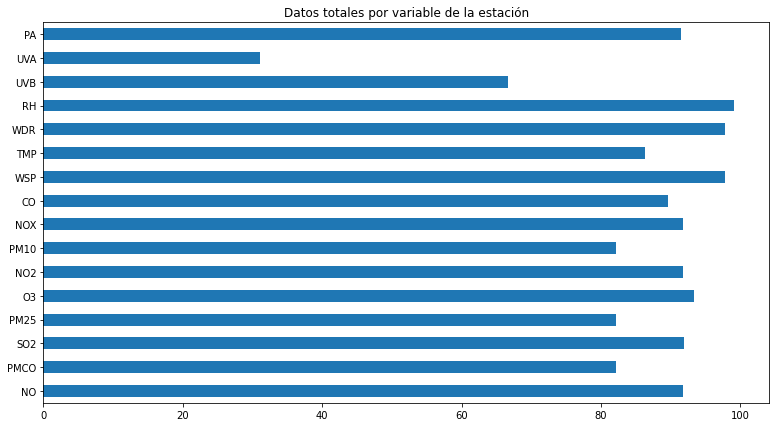

MGH
13
NO
83.66420226359985
PMCO
44.16073384446879
SO2
85.45774005111355
PM25
44.16073384446879
O3
90.74479737130339
NO2
83.66420226359985
PM10
44.16073384446879
NOX
83.66420226359985
CO
91.7602227090179
WSP
83.01615553121577
TMP
86.03048557867835
WDR
83.01615553121577
RH
99.53221978824388


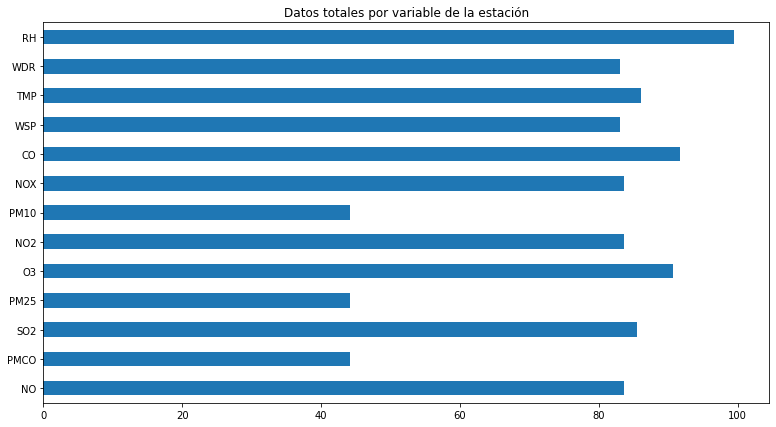

MON
14
NO
78.78787878787878
SO2
76.97152245345016
O3
81.27966411098942
NO2
78.78787878787878
NOX
78.78787878787878
CO
77.25675428988681
PM25
37.139466958744066
WSP
88.1434830230011
TMP
90.53030303030303
WDR
88.1434830230011
RH
90.49835706462213
UVB
67.85094925155165
UVA
86.57813070463673
PA
1.5516611902154072


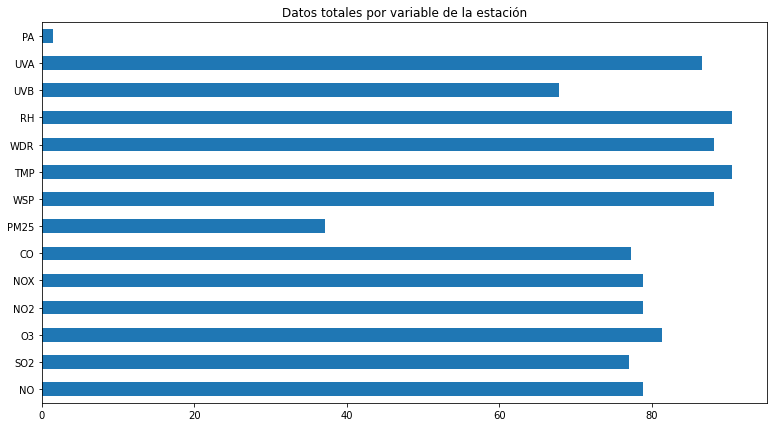

MPA
14
PMCO
22.991967871485944
SO2
74.27893391748813
PM25
22.991967871485944
O3
76.14092734574662
NO2
44.758579773640015
PM10
22.991967871485944
CO
65.1697699890471
WSP
76.52884264330048
TMP
76.54481562614093
WDR
76.52884264330048
RH
76.59501642935378
UVB
5.305312157721796
UVA
5.3098758671047825
PA
77.21568090543994


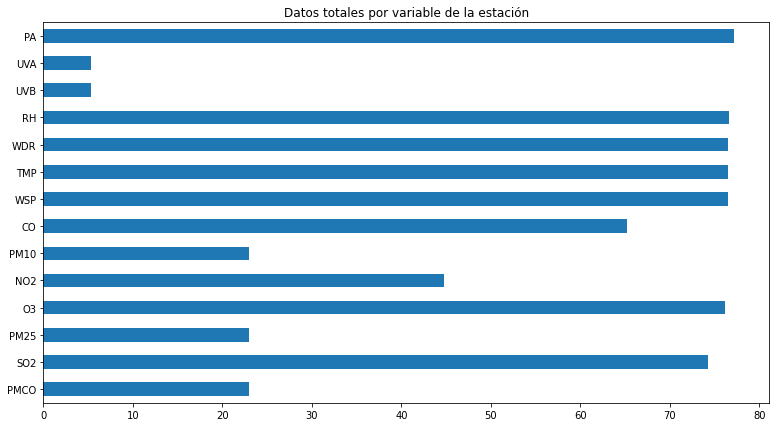

NEZ
12
NO
82.76971522453451
SO2
74.157995618839
PM25
78.92935377875136
O3
84.12513691128149
NO2
82.76971522453451
NOX
82.76971522453451
CO
83.15306681270536
PM10
11.089813800657174
WSP
83.9836619204089
TMP
95.16474990872581
WDR
83.9836619204089
RH
94.54864914202264


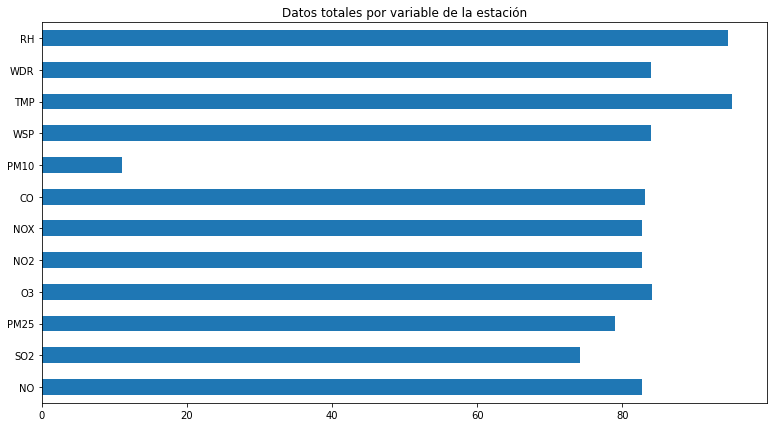

PED
15
NO
90.45043811610077
PMCO
53.68747718145308
SO2
89.00146038700255
PM25
53.68747718145308
O3
90.30668127053669
NO2
90.45043811610077
PM10
53.68747718145308
NOX
90.45043811610077
CO
88.70938298649142
WSP
97.67935377875136
TMP
97.71586345381526
WDR
97.67935377875136
RH
97.72499087258123
UVB
92.97645125958378
UVA
93.0083972252647


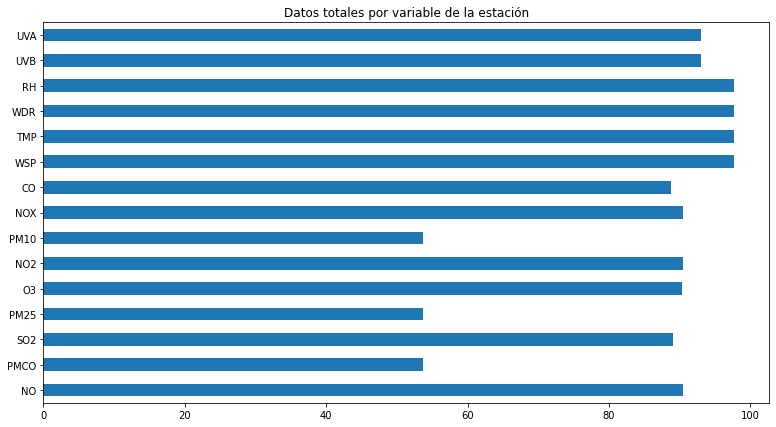

SAG
15
NO
80.29390288426433
PMCO
62.64832055494706
SO2
60.60149689667762
PM25
62.64832055494706
O3
80.06343556042351
NO2
80.29390288426433
PM10
62.64832055494706
NOX
80.29390288426433
CO
78.35432639649507
WSP
92.92168674698796
TMP
85.76350857977364
WDR
92.92168674698796
RH
82.40690032858707
UVB
65.64895947426068
UVA
65.79499817451625


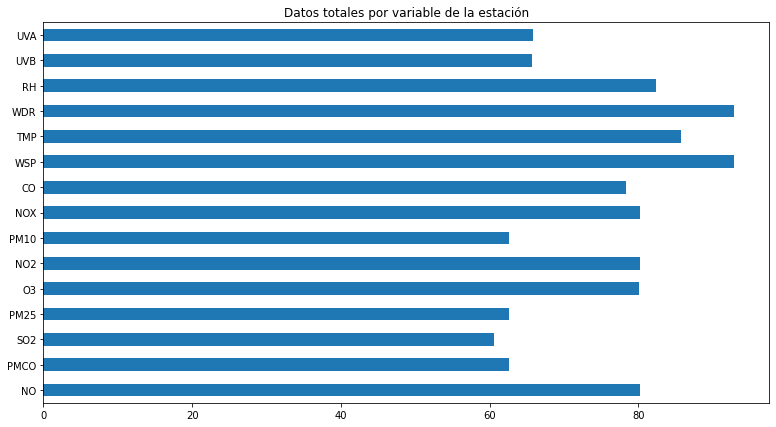

SFE
15
NO
79.98813435560423
PMCO
82.64877692588536
SO2
86.92953632712668
PM25
82.64877692588536
O3
83.76916757940855
NO2
79.98813435560423
PM10
82.64877692588536
NOX
79.98813435560423
CO
79.17807594012413
WSP
80.70235487404162
TMP
93.69067177802117
WDR
80.70235487404162
RH
81.94368382621394
UVB
85.48284045271997
UVA
85.4417670682731


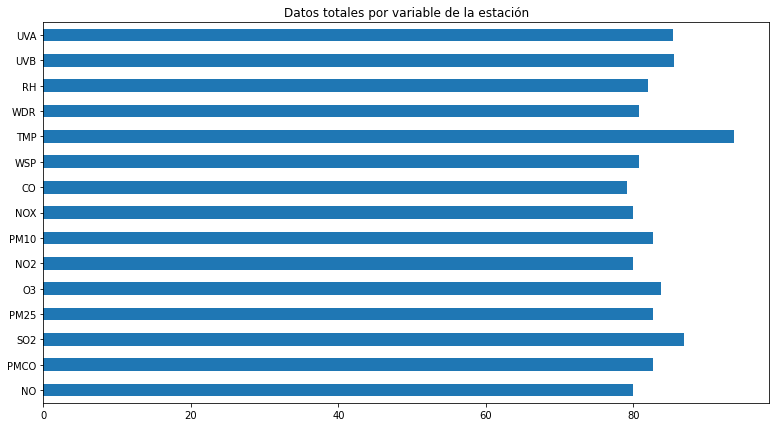

SJA
6
NO
13.43556042351223
SO2
13.28039430449069
O3
13.419587440671778
NO2
13.478915662650602
NOX
13.478915662650602
CO
13.46294267981015
se elimina:  Empty DataFrame
Columns: []
Index: [2017-01-01 01:00:00, 2017-01-01 02:00:00, 2017-01-01 03:00:00, 2017-01-01 04:00:00, 2017-01-01 05:00:00, 2017-01-01 06:00:00, 2017-01-01 07:00:00, 2017-01-01 08:00:00, 2017-01-01 09:00:00, 2017-01-01 10:00:00, 2017-01-01 11:00:00, 2017-01-01 12:00:00, 2017-01-01 13:00:00, 2017-01-01 14:00:00, 2017-01-01 15:00:00, 2017-01-01 16:00:00, 2017-01-01 17:00:00, 2017-01-01 18:00:00, 2017-01-01 19:00:00, 2017-01-01 20:00:00, 2017-01-01 21:00:00, 2017-01-01 22:00:00, 2017-01-01 23:00:00, 2017-01-02 00:00:00, 2017-01-02 01:00:00, 2017-01-02 02:00:00, 2017-01-02 03:00:00, 2017-01-02 04:00:00, 2017-01-02 05:00:00, 2017-01-02 06:00:00, 2017-01-02 07:00:00, 2017-01-02 08:00:00, 2017-01-02 09:00:00, 2017-01-02 10:00:00, 2017-01-02 11:00:00, 2017-01-02 12:00:00, 2017-01-02 13:00:00, 2017-01-02 14:00:00, 2017-01-02 15:0

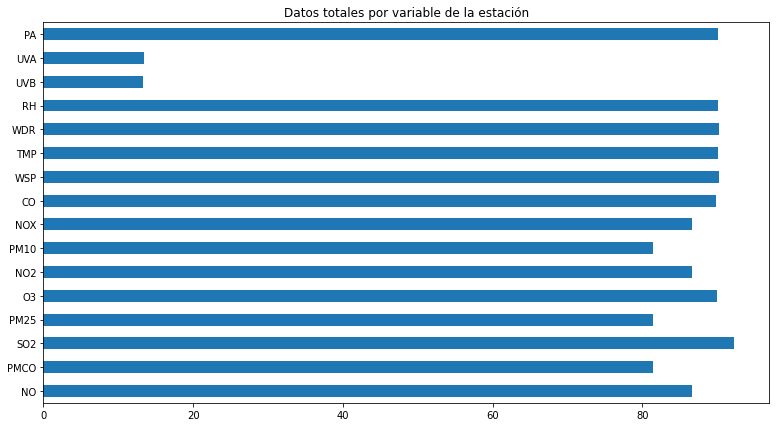

TLI
7
NO
67.94678714859438
SO2
67.75967506389193
O3
68.21148229280759
NO2
67.94678714859438
PM10
44.81334428623585
NOX
67.94678714859438
CO
67.1641109894122


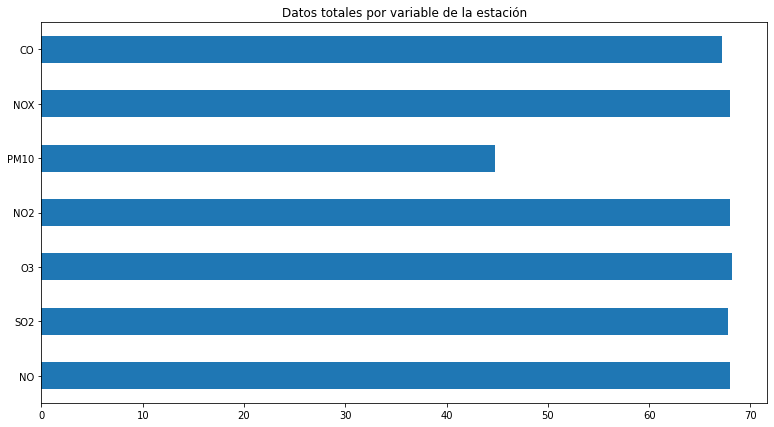

UAX
11
NO
89.0881708652793
SO2
88.32831325301204
PM25
84.05211756115371
O3
91.70317634173055
NO2
89.0881708652793
NOX
89.0881708652793
CO
88.63179992698065
WSP
96.46997079225994
TMP
88.10240963855422
WDR
96.46997079225994
RH
95.31307046367287


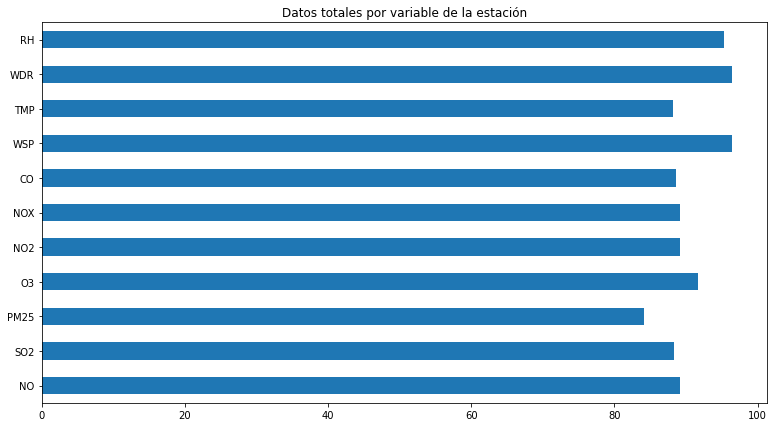

UIZ
13
NO
82.01670317634174
PMCO
57.03952172325666
SO2
82.07831325301204
PM25
57.03952172325666
O3
83.5113179992698
NO2
82.01670317634174
PM10
57.03952172325666
NOX
82.01670317634174
CO
79.6595472800292
WSP
82.97964585615188
TMP
76.017707192406
WDR
82.97964585615188
RH
55.31672143117926


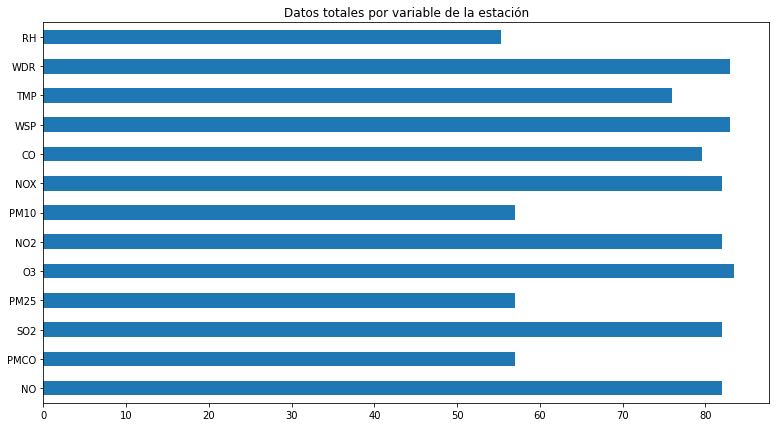

VIF
11
NO
83.73950346841913
SO2
83.76232201533406
O3
84.97398685651697
NO2
83.73950346841913
PM10
77.59446878422781
NOX
83.73950346841913
CO
83.956279664111
WSP
84.37385907265426
TMP
93.34154801022271
WDR
84.37385907265426
RH
96.32621394669587


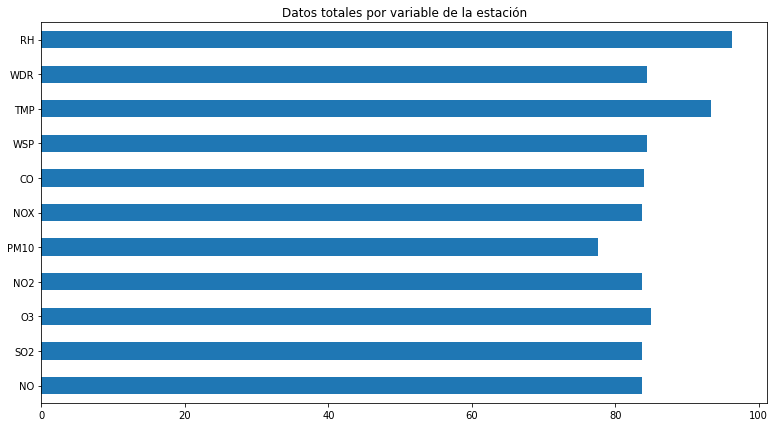

XAL
14
NO
52.822654253377145
PMCO
50.55905439941584
SO2
52.72225264695144
PM25
50.55905439941584
O3
54.31498722161373
NO2
52.822654253377145
PM10
50.55905439941584
NOX
52.822654253377145
CO
52.41192040890836
WSP
87.73046732384081
TMP
87.68939393939394
WDR
87.73046732384081
RH
87.71449434100036
PA
86.13088718510406


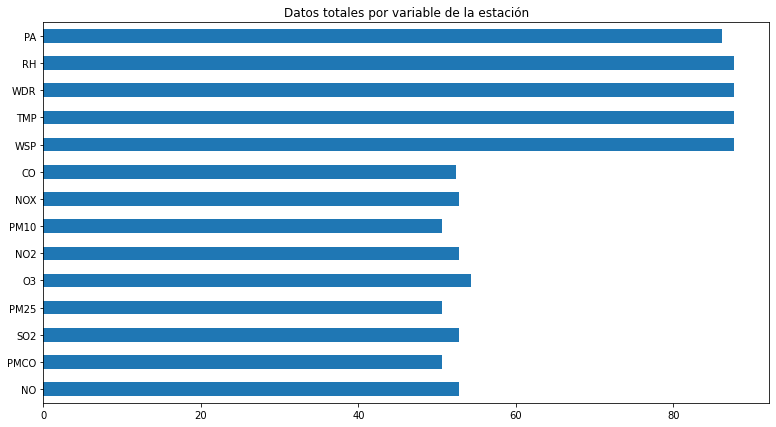

AJU
8
PM25
45.79682365826944
O3
60.318546914932455
NO2
0.0022818546914932457
NOX
0.006845564074479737
WSP
70.58004746257758
TMP
62.878787878787875
WDR
70.58004746257758
RH
45.16474990872581


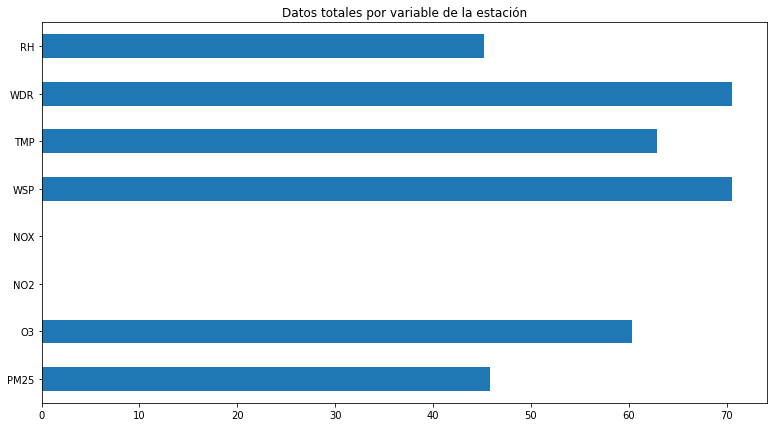

GAM
9
PM25
65.17661555312158
O3
88.66830960204454
PMCO
32.988773274917854
NO2
53.64640379700621
PM10
32.988773274917854
WSP
91.69404892296458
TMP
96.0158817086528
WDR
91.69404892296458
RH
93.34154801022271


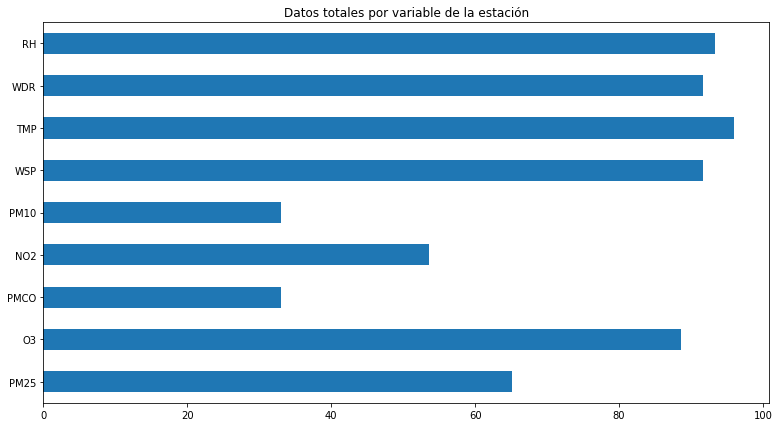

FAR
9
SO2
85.4014598540146
PM25
86.96776155717761
O3
80.74817518248175
NO2
85.64476885644768
CO
60.37484793187348
WDR
85.36724452554745
WSP
85.36724452554745
TMP
60.03269464720194
RH
60.01368613138686


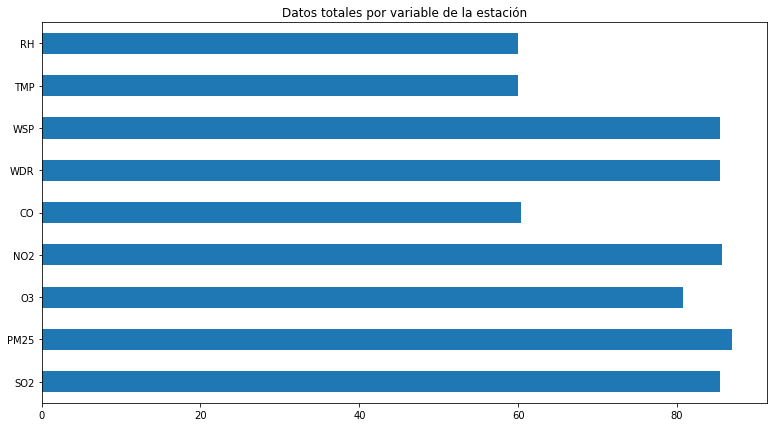

SAC
11
SO2
69.16058394160584
PM25
76.57010340632604
O3
85.49650243309003
NO2
86.42031630170317
NO
86.42031630170317
CO
80.42883211678833
NOX
86.42031630170317
WDR
90.8036800486618
WSP
90.8036800486618
TMP
13.648114355231144
RH
13.644312652068127


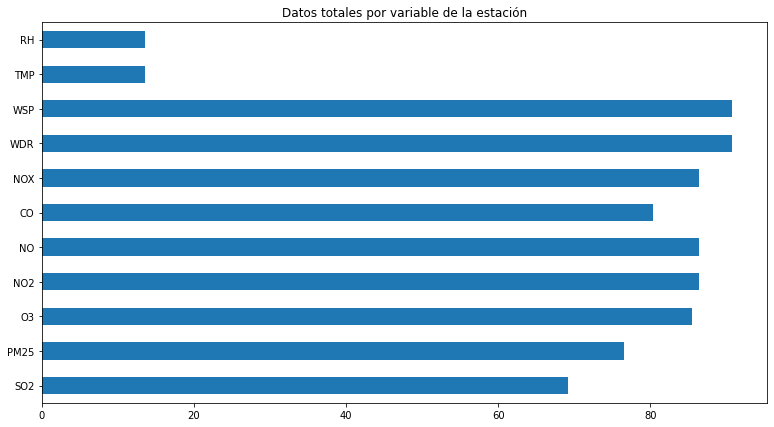

LAA
7
WSP
93.0403431909456
TMP
94.13335158817087
WDR
93.0426250456371
RH
92.60679079956188
UVB
89.43729463307777
UVA
89.47836801752464
PA
97.293720335889


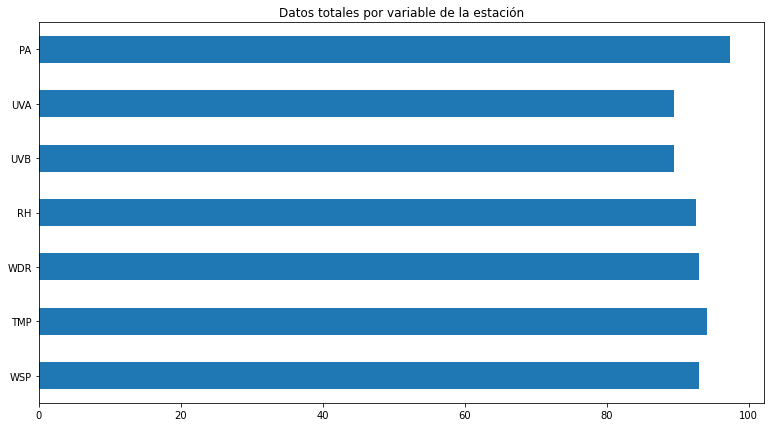

In [27]:
from IPython.display import display

for idx,df in enumerate(newDfs):
  print(df.name)
  print(len(df.columns))
  #count = df.count()
  count= (df.count() * 100)/len(df.index)
  for i, s in count.items():
    print(i)
    print(s)
    if s < 20.0:
      df.drop(i, axis=1, inplace=True)

  if len(df.columns) == 0:
    print('se elimina: ', df)
    del newDfs[idx]
    continue
  count.plot(kind='barh').set_title('Datos totales por variable de la estación')
  plt.show()

ACO
11


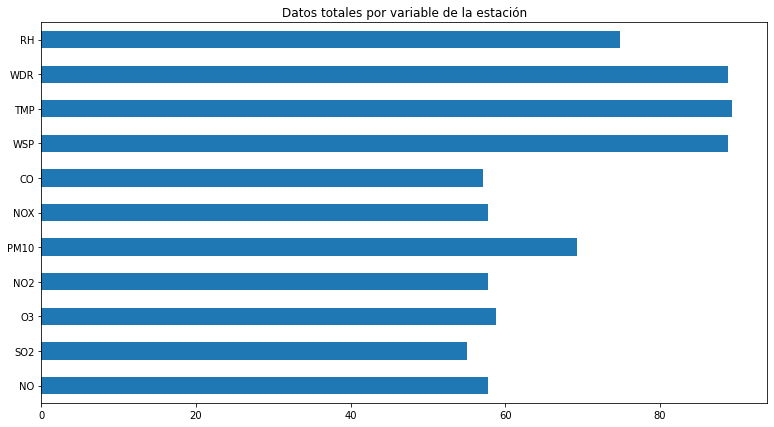

AJM
14


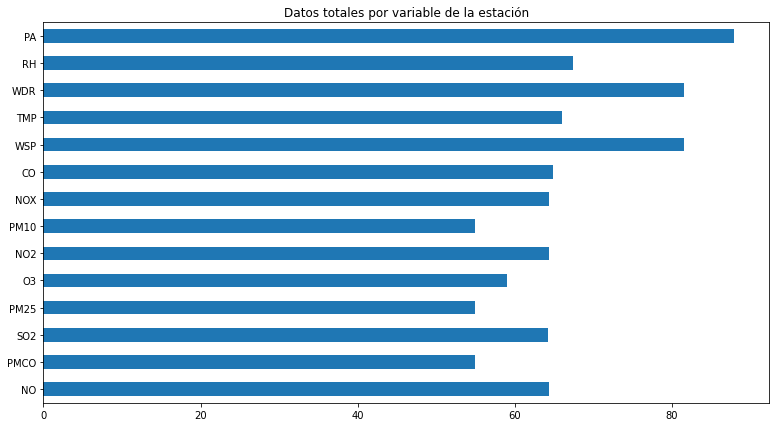

ATI
7


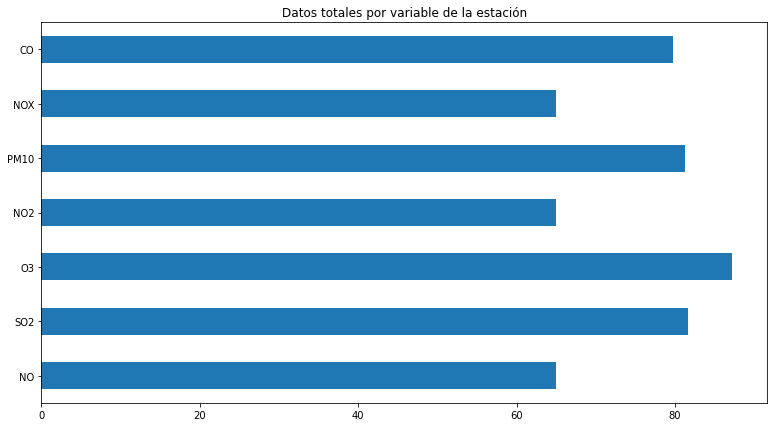

BJU
11


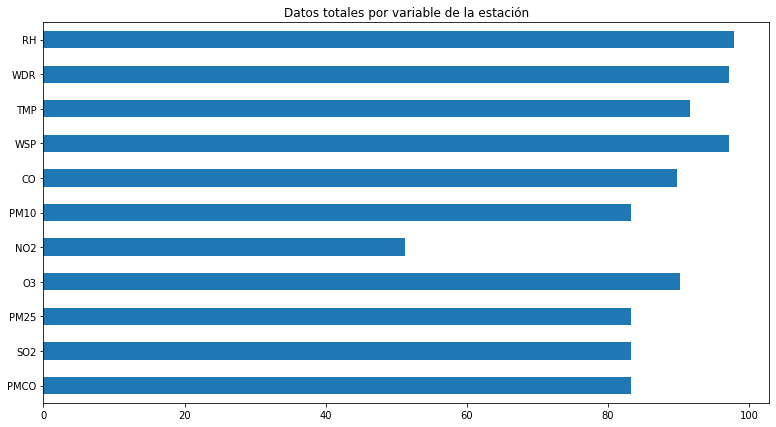

CAM
9


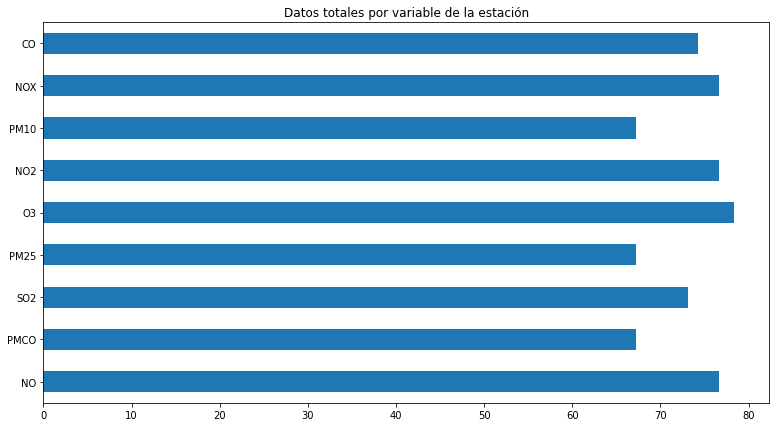

CCA
7


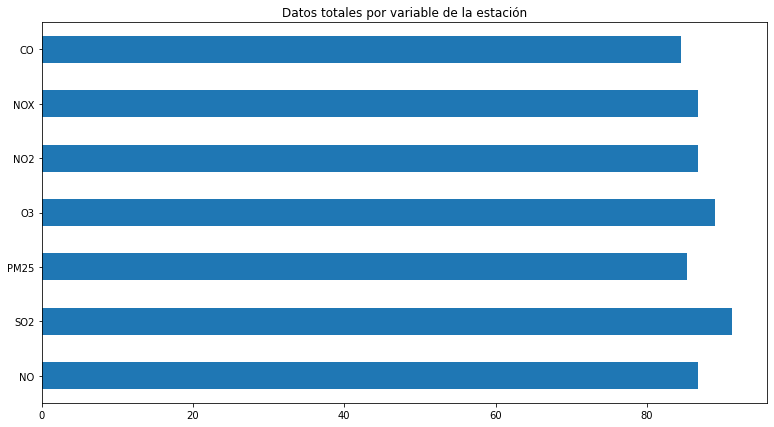

CHO
13


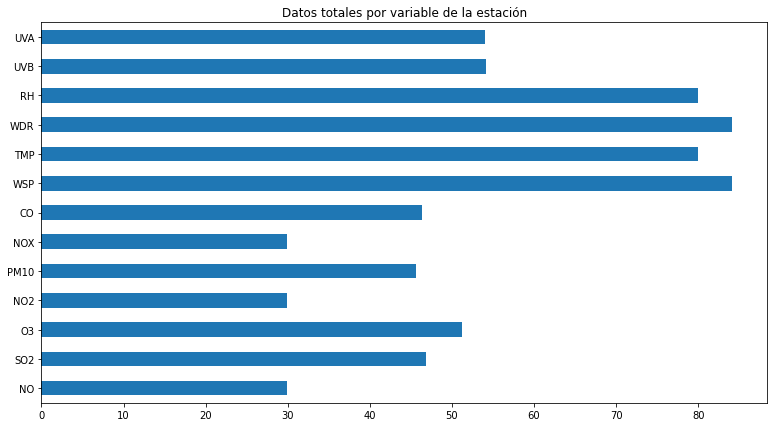

CUA
11


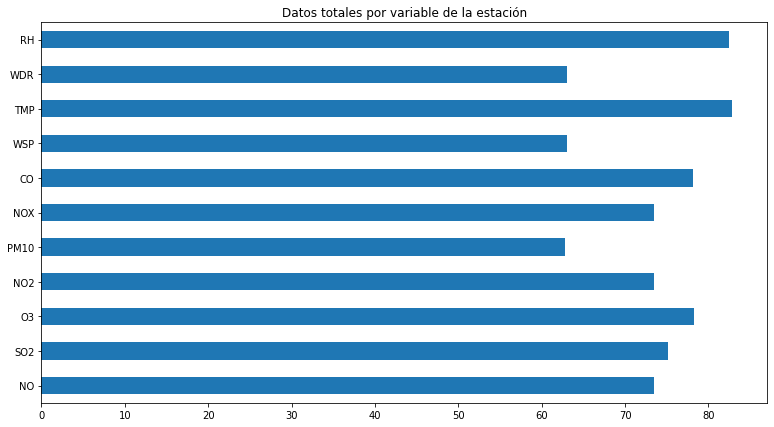

CUT
13


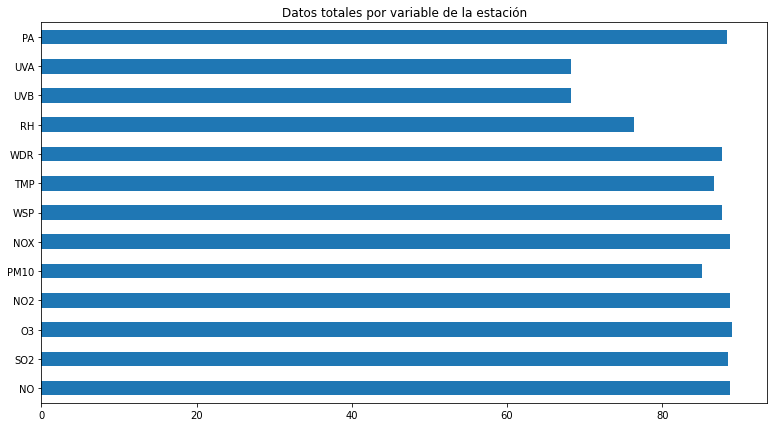

FAC
13


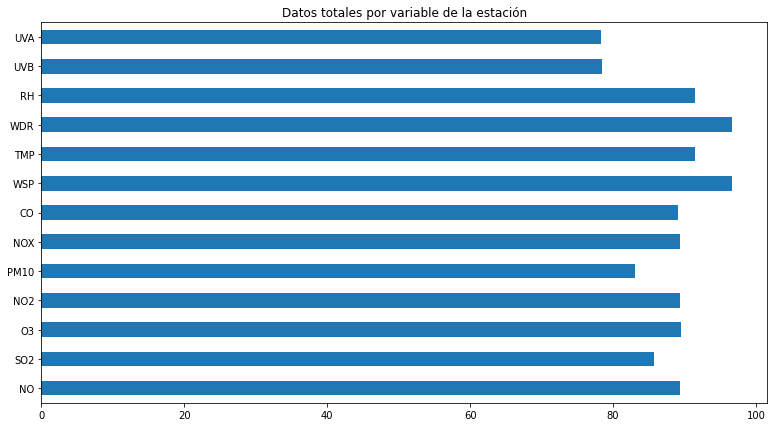

HGM
14


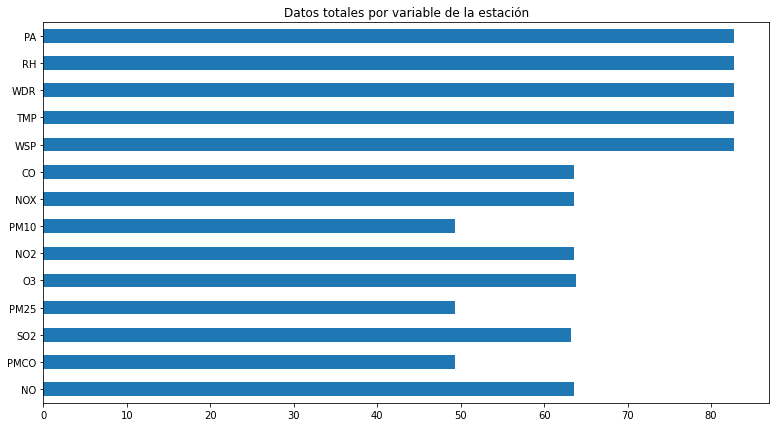

INN
11


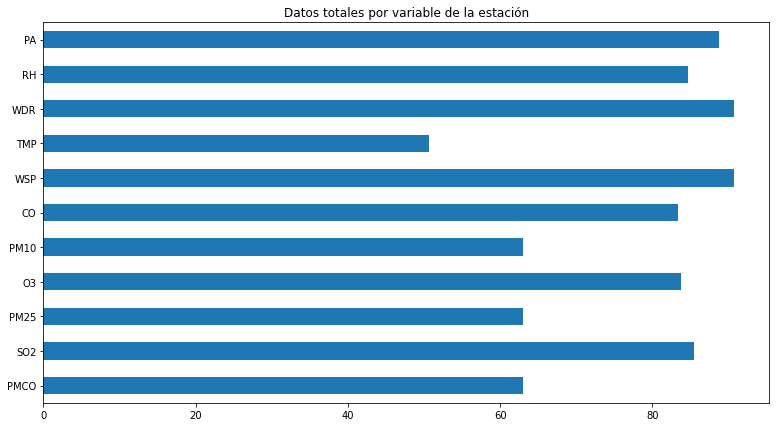

IZT
7


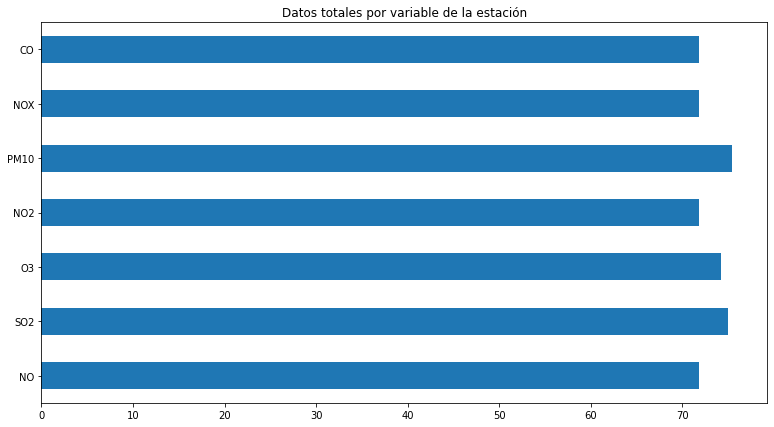

LLA
6


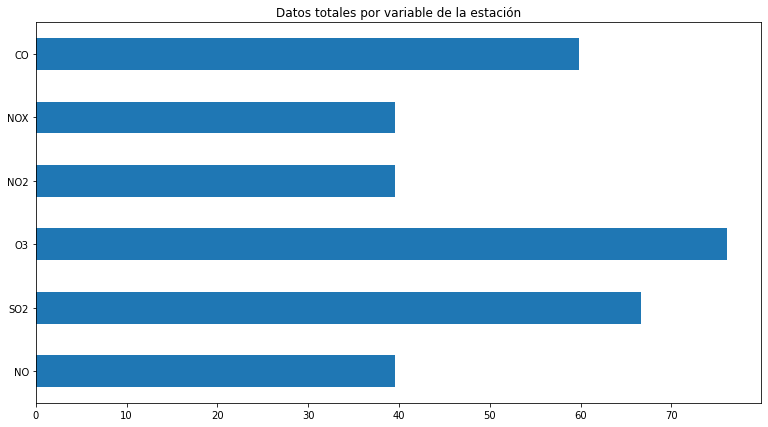

LPR
3


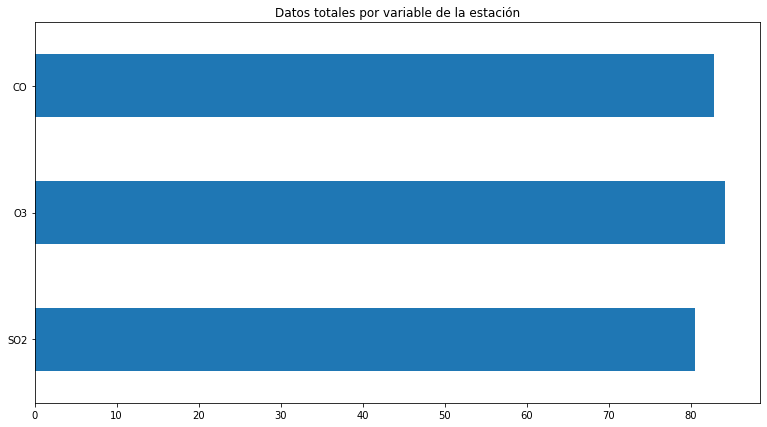

MER
16


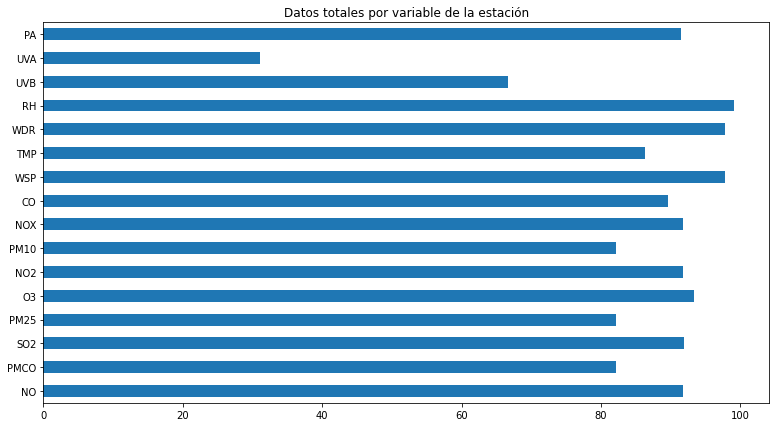

MGH
13


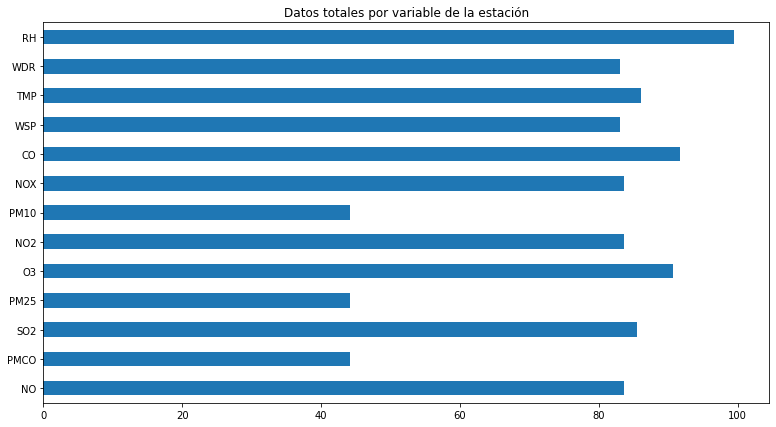

MON
13


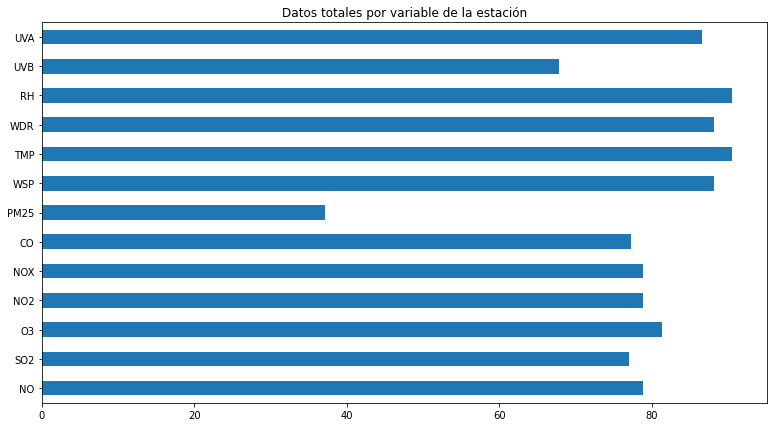

MPA
12


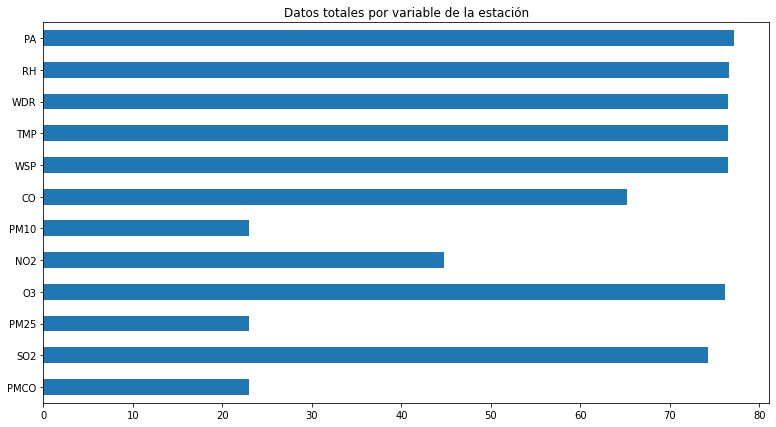

NEZ
11


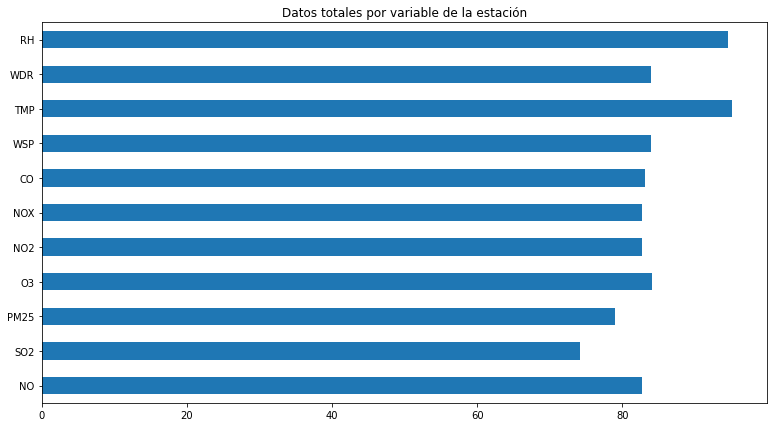

PED
15


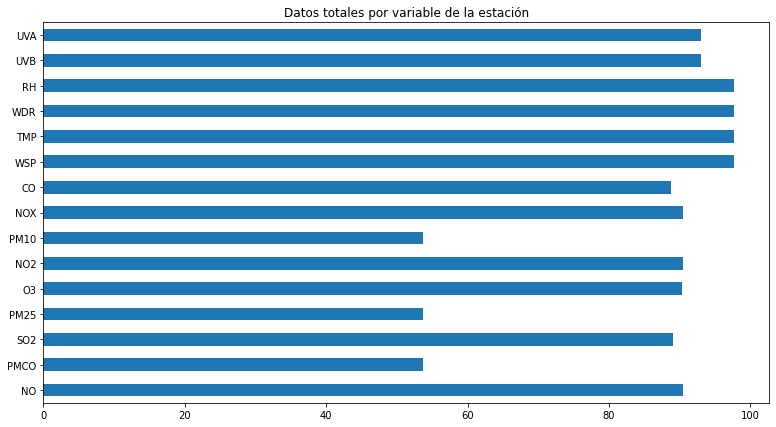

SAG
15


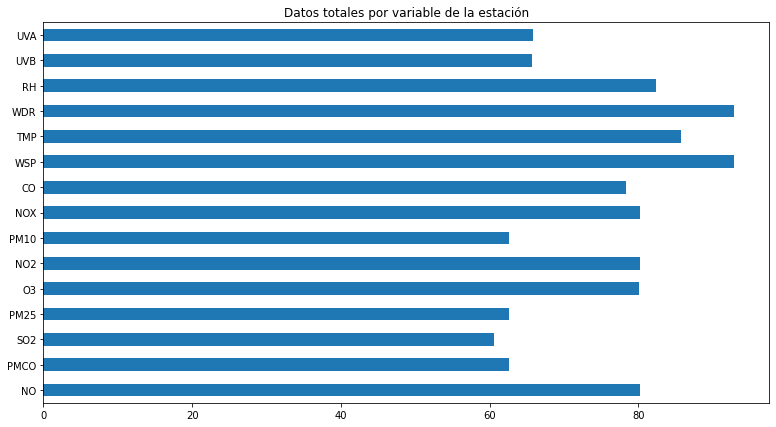

SFE
15


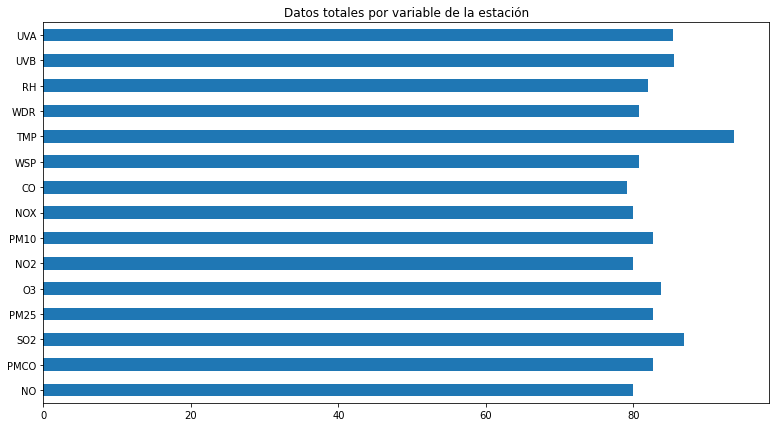

TAH
11


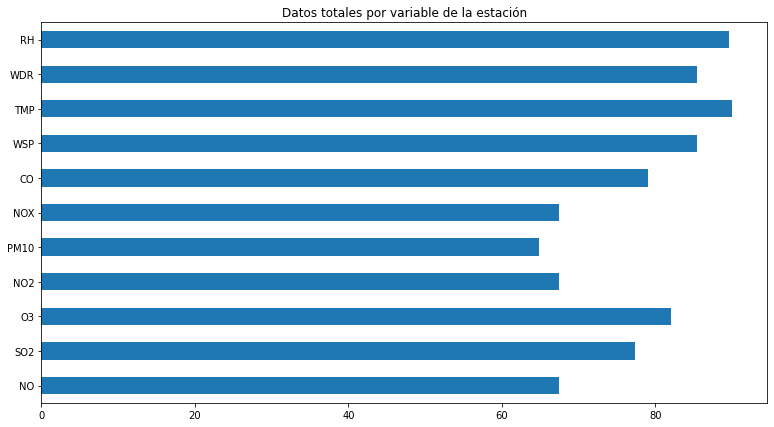

TLA
14


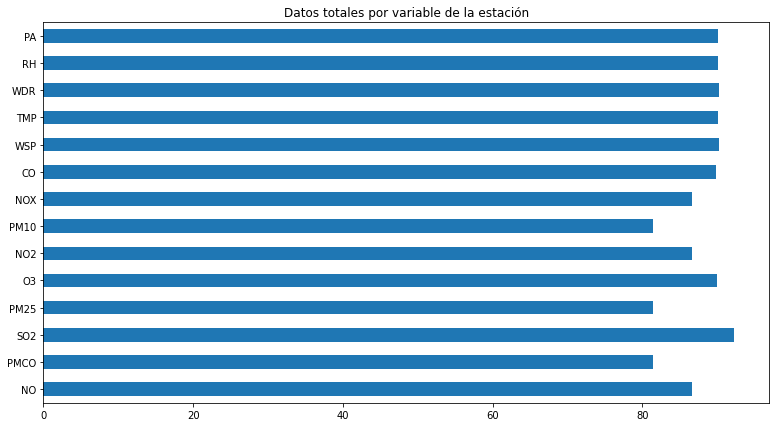

TLI
7


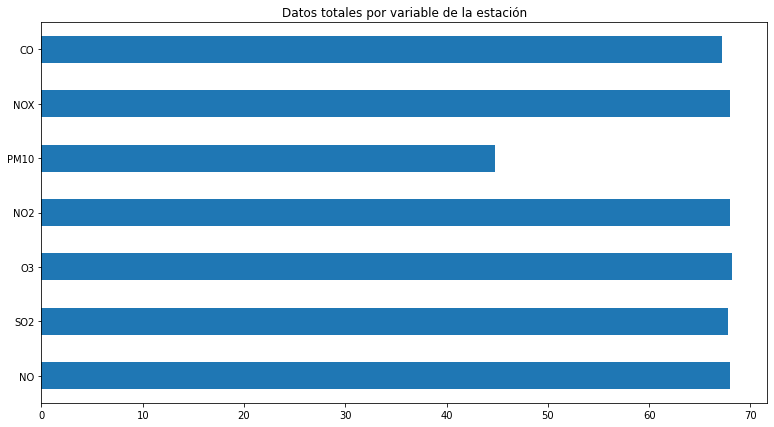

UAX
11


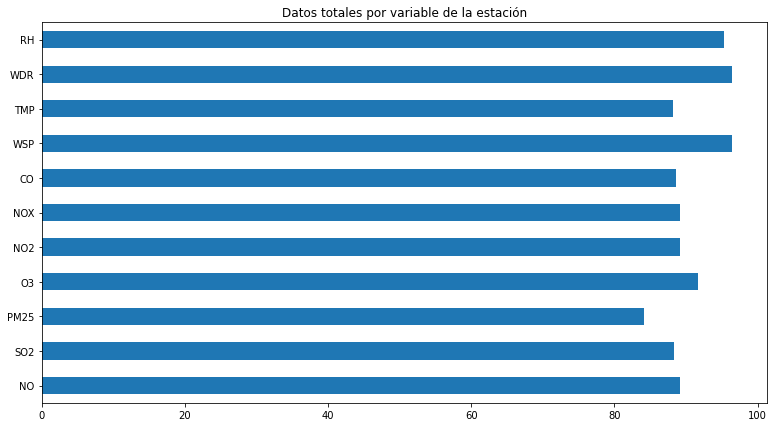

UIZ
13


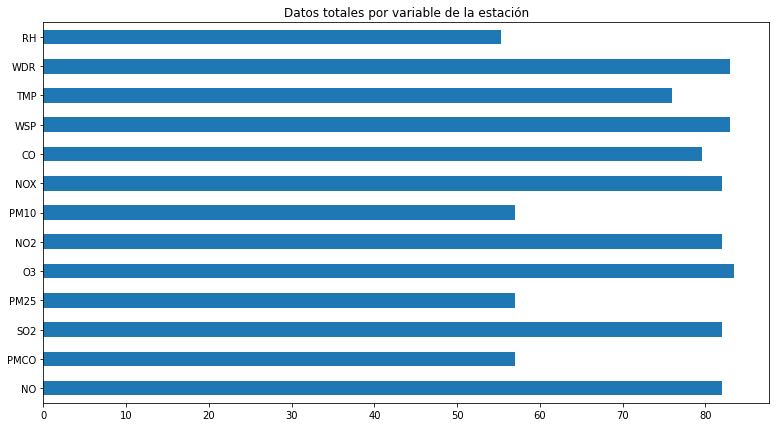

VIF
11


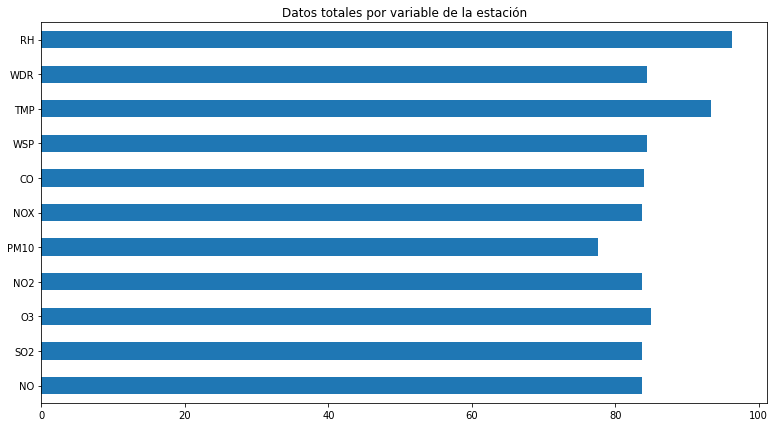

XAL
14


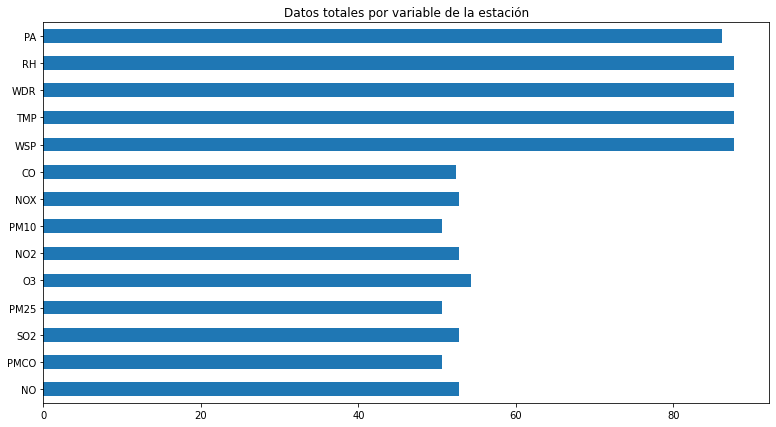

AJU
6


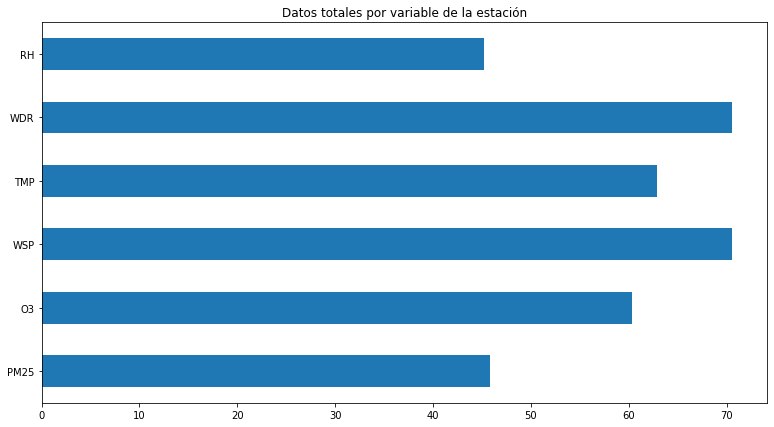

GAM
9


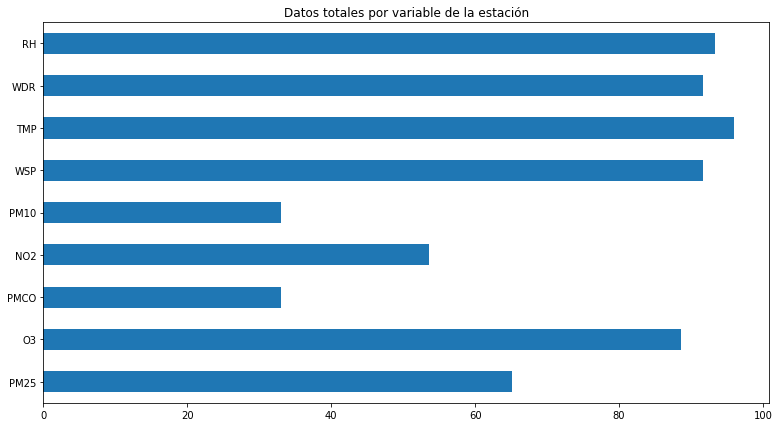

FAR
9


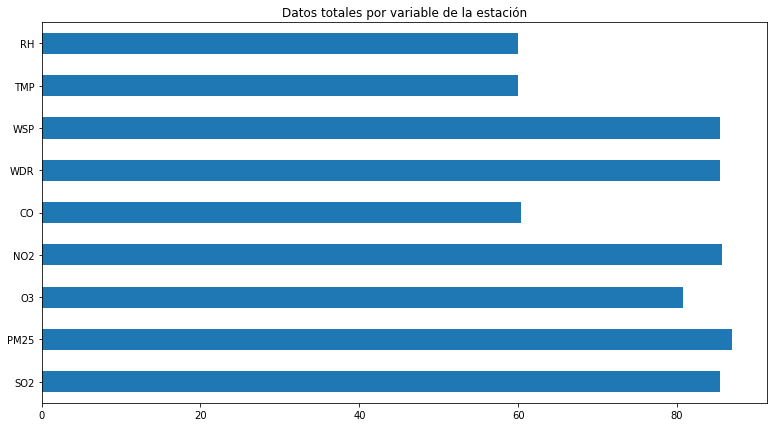

SAC
9


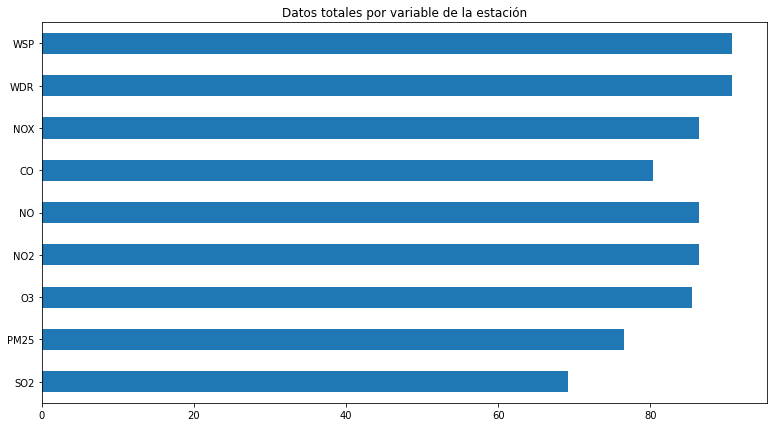

LAA
7


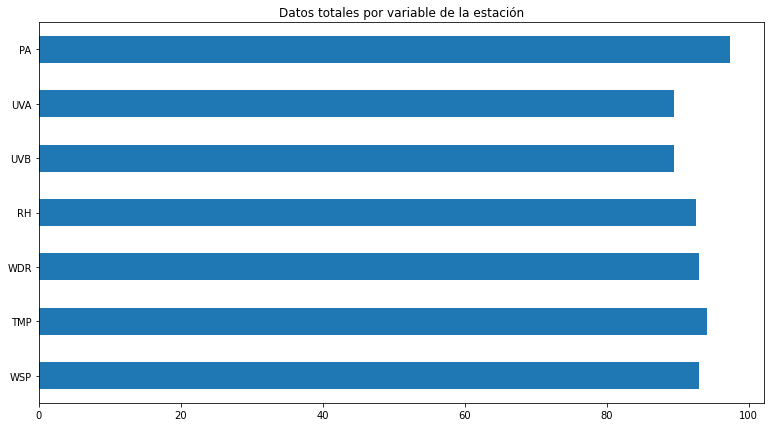

In [28]:
for df in newDfs:
  print(df.name)
  print(len(df.columns))
  count= (df.count() * 100)/len(df.index)
  count.plot(kind='barh').set_title('Datos totales por variable de la estación')
  plt.show()

In [30]:
for df in newDfs:
  print(df.name)

ACO
AJM
ATI
BJU
CAM
CCA
CHO
CUA
CUT
FAC
HGM
INN
IZT
LLA
LPR
MER
MGH
MON
MPA
NEZ
PED
SAG
SFE
TAH
TLA
TLI
UAX
UIZ
VIF
XAL
AJU
GAM
FAR
SAC
LAA


In [31]:
BJU = newDfs[3]

In [32]:
FAR = newDfs[32]

In [33]:
SFE = newDfs[22]

In [34]:
SAC = newDfs[33]

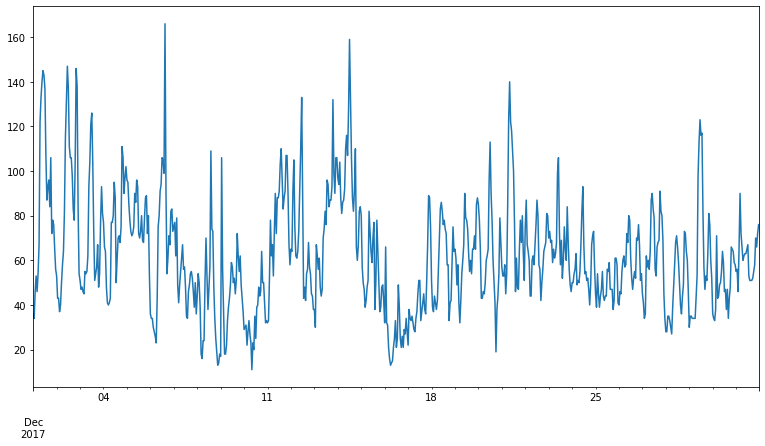

In [35]:
BJU['PM10'].loc['2017-12'].plot()

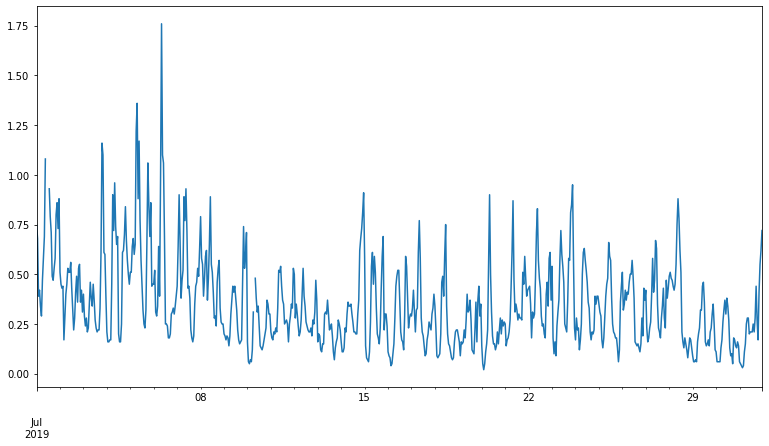

In [36]:
FAR['CO'].loc['2019-07'].plot()

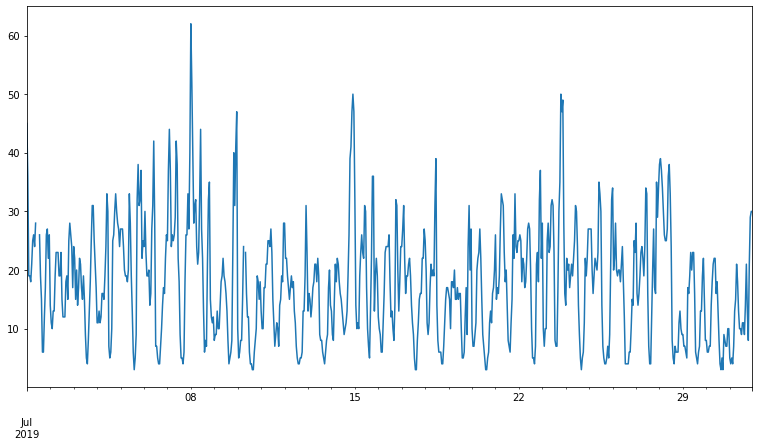

In [37]:
FAR['NO2'].loc['2019-07'].plot()

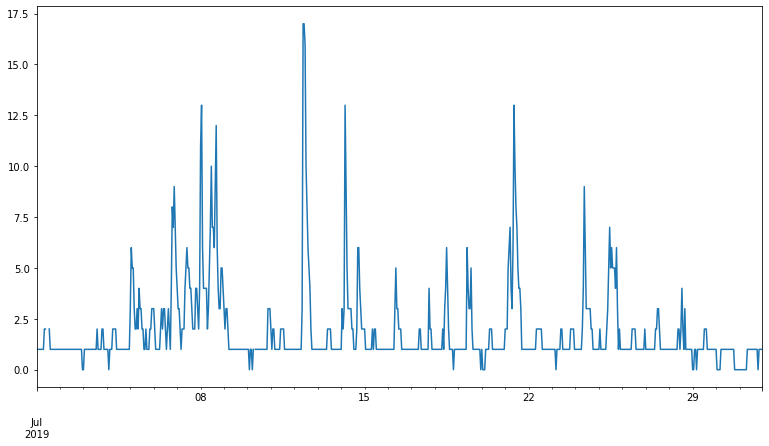

In [38]:
FAR['SO2'].loc['2019-07'].plot()

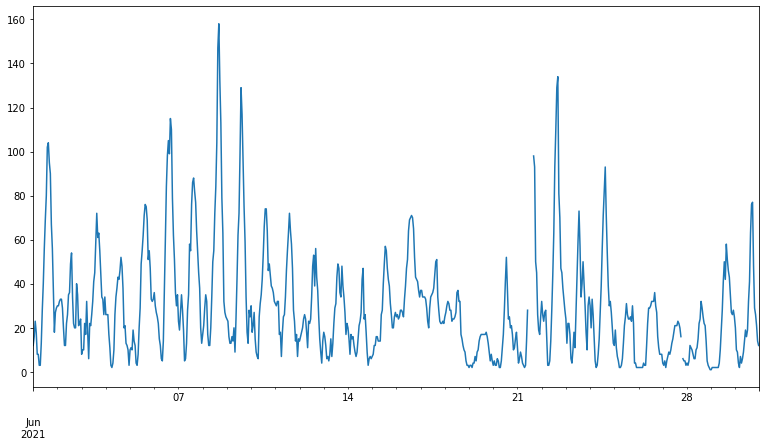

In [39]:
SFE['O3'].loc['2021-06'].plot()

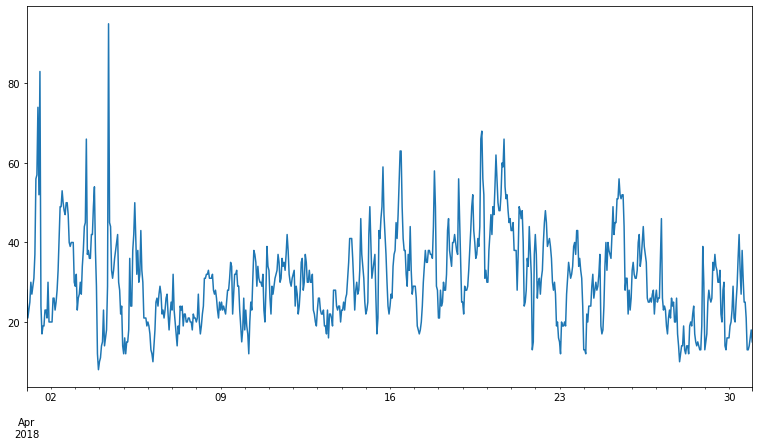

In [40]:
SAC['PM25'].loc['2018-04'].plot()

Como ejemplo, obtenemos un dataframe de nuestra lista

In [41]:
BJU = newDfs[3]

La estructura final de nuestros datos sería la siguiente:

Cada dataframe contiene los datos de una estacion de monitoreo.

Donde tenemos:

- Una columna índice en formato datetime: AAAA-MM-DD HH:MM:SS
- Cada columna posterior tiene los atributos o contaminantes medidios en esta estacion

- El numero total de filas es 43824 correspondiente a las 43284 horas del 2017 al 2021.


In [42]:
BJU

,PMCO,SO2,PM25,O3,NO2,PM10,CO,WSP,TMP,WDR,RH
2017-01-01 01:00:00,11.0,NaN,40.0,2.0,NaN,51.0,1.00,0.7,13.5,226.0,64.0
2017-01-01 02:00:00,13.0,NaN,58.0,1.0,NaN,71.0,1.30,0.7,12.9,148.0,68.0
2017-01-01 03:00:00,13.0,NaN,71.0,2.0,NaN,83.0,1.10,0.9,13.2,190.0,64.0
2017-01-01 04:00:00,17.0,NaN,94.0,2.0,NaN,111.0,1.20,0.7,12.9,170.0,67.0
2017-01-01 05:00:00,20.0,NaN,103.0,2.0,NaN,124.0,1.40,0.8,12.3,150.0,72.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 20:00:00,21.0,1.0,16.0,28.0,25.0,38.0,0.55,1.1,17.9,103.0,41.0
2021-12-31 21:00:00,18.0,1.0,21.0,14.0,37.0,39.0,0.68,1.1,16.8,71.0,45.0
2021-12-31 22:00:00,18.0,1.0,27.0,16.0,33.0,45.0,0.66,1.0,16.0,142.0,47.0
2021-12-31 23:00:00,19.0,1.0,33.0,10.0,39.0,51.0,0.84,1.0,15.1,179.0,50.0


In [43]:
newDfsOfVariables = []

myNewDf = pd.DataFrame(index = newDfs[0].index)

for variable in columns: 
  myNewDf = pd.DataFrame(index = newDfs[0].index)
  for df in newDfs:
    if variable in df:
      name = df.name 
      myNewDf[name] = df[variable]
  myNewDf.name = variable
  # myNewDf.to_csv(f"2017-2021{myNewDf.name}.csv")
  newDfsOfVariables.append(myNewDf)




In [44]:
CO = newDfsOfVariables[6]

In [45]:
PM10 = BJU['PM10'].loc['2017-12']
CO = FAR['CO'].loc['2019-07']
NO2 = FAR['NO2'].loc['2019-07']
SO2 = FAR['SO2'].loc['2019-07']
O3 = SFE['O3'].loc['2021-06']
PM25 = SAC['PM25'].loc['2018-04']


In [46]:
for df in newDfsOfVariables:
  print(df.name)

NO
SO2
O3
NO2
PM10
NOX
CO
WSP
TMP
WDR
RH
PMCO
PM25
PA
UVB
UVA


In [47]:
SO2_full = newDfsOfVariables[1]
O3_full = newDfsOfVariables[2]
NO2_full = newDfsOfVariables[3]
PM10_full = newDfsOfVariables[4]
CO_full = newDfsOfVariables[6]
PM25_full = newDfsOfVariables[12]

In [48]:

PM25_full.name

'PM25'

In [49]:

CO_full.name

'CO'

In [50]:

PM10_full.name

'PM10'

In [51]:

NO2_full.name

'NO2'

In [52]:

O3_full.name

'O3'

In [53]:
SO2_full.name

'SO2'

In [54]:
# coding=utf-8
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

'''Utility functions for GAIN.

(1) normalization: MinMax Normalizer
(2) renormalization: Recover the data from normalized data
(3) rounding: Handle categorical variables after imputation
(4) rmse_loss: Evaluate imputed data in terms of RMSE
(5) xavier_init: Xavier initialization
(6) binary_sampler: sample binary random variables
(7) uniform_sampler: sample uniform random variables
(8) sample_batch_index: sample random batch index
'''
 

tf.disable_v2_behavior()


def normalization (data, parameters=None):
  '''Normalize data in [0, 1] range.
  
  Args:
    - data: original data
  
  Returns:
    - norm_data: normalized data
    - norm_parameters: min_val, max_val for each feature for renormalization
  '''

  # Parameters
  _, dim = data.shape
  norm_data = data.copy()
  
  if parameters is None:
  
    # MixMax normalization
    min_val = np.zeros(dim)
    max_val = np.zeros(dim)
    
    # For each dimension
    for i in range(dim):
      min_val[i] = np.nanmin(norm_data[:,i])
      norm_data[:,i] = norm_data[:,i] - np.nanmin(norm_data[:,i])
      max_val[i] = np.nanmax(norm_data[:,i])
      norm_data[:,i] = norm_data[:,i] / (np.nanmax(norm_data[:,i]) + 1e-6)   
      
    # Return norm_parameters for renormalization
    norm_parameters = {'min_val': min_val,
                       'max_val': max_val}

  else:
    min_val = parameters['min_val']
    max_val = parameters['max_val']
    
    # For each dimension
    for i in range(dim):
      norm_data[:,i] = norm_data[:,i] - min_val[i]
      norm_data[:,i] = norm_data[:,i] / (max_val[i] + 1e-6)  
      
    norm_parameters = parameters    
      
  return norm_data, norm_parameters


def renormalization (norm_data, norm_parameters):
  '''Renormalize data from [0, 1] range to the original range.
  
  Args:
    - norm_data: normalized data
    - norm_parameters: min_val, max_val for each feature for renormalization
  
  Returns:
    - renorm_data: renormalized original data
  '''
  
  min_val = norm_parameters['min_val']
  max_val = norm_parameters['max_val']

  _, dim = norm_data.shape
  renorm_data = norm_data.copy()
    
  for i in range(dim):
    renorm_data[:,i] = renorm_data[:,i] * (max_val[i] + 1e-6)   
    renorm_data[:,i] = renorm_data[:,i] + min_val[i]
    
  return renorm_data


def rounding (imputed_data, data_x):
  '''Round imputed data for categorical variables.
  
  Args:
    - imputed_data: imputed data
    - data_x: original data with missing values
    
  Returns:
    - rounded_data: rounded imputed data
  '''
  
  _, dim = data_x.shape
  rounded_data = imputed_data.copy()
  
  for i in range(dim):
    temp = data_x[~np.isnan(data_x[:, i]), i]
    # Only for the categorical variable
    if len(np.unique(temp)) < 20:
      rounded_data[:, i] = np.round(rounded_data[:, i])
      
  return rounded_data


def rmse_loss (ori_data, imputed_data, data_m):
  '''Compute RMSE loss between ori_data and imputed_data
  
  Args:
    - ori_data: original data without missing values
    - imputed_data: imputed data
    - data_m: indicator matrix for missingness
    
  Returns:
    - rmse: Root Mean Squared Error
  '''
  
  ori_data, norm_parameters = normalization(ori_data)
  imputed_data, _ = normalization(imputed_data, norm_parameters)
    
  # Only for missing values
  nominator = np.nansum(((1-data_m) * ori_data - (1-data_m) * imputed_data)**2)
  denominator = np.sum(1-data_m)
  
  rmse = np.sqrt(nominator/float(denominator))
  
  return rmse


def xavier_init(size):
  '''Xavier initialization.
  
  Args:
    - size: vector size
    
  Returns:
    - initialized random vector.
  '''
  in_dim = size[0]
  xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
  return tf.random_normal(shape = size, stddev = xavier_stddev)
      

def binary_sampler(p, rows, cols):
  '''Sample binary random variables.
  
  Args:
    - p: probability of 1
    - rows: the number of rows
    - cols: the number of columns
    
  Returns:
    - binary_random_matrix: generated binary random matrix.
  '''
  unif_random_matrix = np.random.uniform(0., 1., size = [rows, cols])
  binary_random_matrix = 1*(unif_random_matrix < p)
  return binary_random_matrix


def uniform_sampler(low, high, rows, cols):
  '''Sample uniform random variables.
  
  Args:
    - low: low limit
    - high: high limit
    - rows: the number of rows
    - cols: the number of columns
    
  Returns:
    - uniform_random_matrix: generated uniform random matrix.
  '''
  return np.random.uniform(low, high, size = [rows, cols])       


def sample_batch_index(total, batch_size):
  '''Sample index of the mini-batch.
  
  Args:
    - total: total number of samples
    - batch_size: batch size
    
  Returns:
    - batch_idx: batch index
  '''
  total_idx = np.random.permutation(total)
  batch_idx = total_idx[:batch_size]
  return batch_idx
  

  


Instructions for updating:
non-resource variables are not supported in the long term


In [55]:
# coding=utf-8
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

'''Data loader for UCI letter, spam and MNIST datasets.
'''

#def data_loader (data_name, miss_rate):
def data_loader(np_array, miss_rate, imputate):
  '''Loads datasets and introduce missingness.
  
  Args:
    - data_name: letter, spam, or mnist
    - miss_rate: the probability of missing components
    
  Returns:
    data_x: original data
    miss_data_x: data with missing values
    data_m: indicator matrix for missing components
  '''
  
  # Load data
  # if data_name in ['letter', 'spam', 'PM10']:
  #   file_name = 'data/'+data_name+'.csv'
  #   data_x = np.loadtxt(file_name, delimiter=",", skiprows=1)
  # elif data_name == 'mnist':
  #   (data_x, _), _ = mnist.load_data()
  #   data_x = np.reshape(np.asarray(data_x), [60000, 28*28]).astype(float)

  #data_x = array2

  # Parameters
  no, dim = np_array.shape

  if imputate:
    data_m = np.where(np_array, 0, 1)
    boolean = np.isnan(np_array)
    data_m = 1*boolean
    miss_data_x = np_array.copy()
  else:
    data_m = binary_sampler(1-miss_rate, no, dim)
    miss_data_x = np_array.copy()
    miss_data_x[data_m == 0] = np.nan
  
      
  return np_array, miss_data_x, data_m


In [56]:
# coding=utf-8
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

'''GAIN function.
Date: 2020/02/28
Reference: J. Yoon, J. Jordon, M. van der Schaar, "GAIN: Missing Data 
           Imputation using Generative Adversarial Nets," ICML, 2018.
Paper Link: http://proceedings.mlr.press/v80/yoon18a/yoon18a.pdf
Contact: jsyoon0823@gmail.com
'''

# Necessary packages
#import tensorflow as tf
##IF USING TF 2 use following import to still use TF < 2.0 Functionalities
tf.disable_v2_behavior()

# from tqdm import tqdm

# from utils import normalization, renormalization, rounding
# from utils import xavier_init
# from utils import binary_sampler, uniform_sampler, sample_batch_index


def gain (data_x, gain_parameters):
  '''Impute missing values in data_x
  
  Args:
    - data_x: original data with missing values
    - gain_parameters: GAIN network parameters:
      - batch_size: Batch size
      - hint_rate: Hint rate
      - alpha: Hyperparameter
      - iterations: Iterations
      
  Returns:
    - imputed_data: imputed data
  '''
  # Define mask matrix
  data_m = 1-np.isnan(data_x)
  
  # System parameters
  batch_size = gain_parameters['batch_size']
  hint_rate = gain_parameters['hint_rate']
  alpha = gain_parameters['alpha']
  iterations = gain_parameters['iterations']
  
  # Other parameters
  no, dim = data_x.shape
  
  # Hidden state dimensions
  h_dim = int(dim)
  
  # Normalization
  norm_data, norm_parameters = normalization(data_x)
  norm_data_x = np.nan_to_num(norm_data, 0)
  
  ## GAIN architecture   
  # Input placeholders
  # Data vector
  X = tf.placeholder(tf.float32, shape = [None, dim])
  # Mask vector 
  M = tf.placeholder(tf.float32, shape = [None, dim])
  # Hint vector
  H = tf.placeholder(tf.float32, shape = [None, dim])
  
  # Discriminator variables
  D_W1 = tf.Variable(xavier_init([dim*2, h_dim])) # Data + Hint as inputs
  D_b1 = tf.Variable(tf.zeros(shape = [h_dim]))
  
  D_W2 = tf.Variable(xavier_init([h_dim, h_dim]))
  D_b2 = tf.Variable(tf.zeros(shape = [h_dim]))
  
  D_W3 = tf.Variable(xavier_init([h_dim, dim]))
  D_b3 = tf.Variable(tf.zeros(shape = [dim]))  # Multi-variate outputs
  
  theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3]
  
  #Generator variables
  # Data + Mask as inputs (Random noise is in missing components)
  G_W1 = tf.Variable(xavier_init([dim*2, h_dim]))  
  G_b1 = tf.Variable(tf.zeros(shape = [h_dim]))
  
  G_W2 = tf.Variable(xavier_init([h_dim, h_dim]))
  G_b2 = tf.Variable(tf.zeros(shape = [h_dim]))
  
  G_W3 = tf.Variable(xavier_init([h_dim, dim]))
  G_b3 = tf.Variable(tf.zeros(shape = [dim]))
  
  theta_G = [G_W1, G_W2, G_W3, G_b1, G_b2, G_b3]
  
  ## GAIN functions
  # Generator
  def generator(x,m):
    # Concatenate Mask and Data
    inputs = tf.concat(values = [x, m], axis = 1) 
    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
    G_h2 = tf.nn.relu(tf.matmul(G_h1, G_W2) + G_b2)   
    # MinMax normalized output
    G_prob = tf.nn.sigmoid(tf.matmul(G_h2, G_W3) + G_b3) 
    return G_prob
      
  # Discriminator
  def discriminator(x, h):
    # Concatenate Data and Hint
    inputs = tf.concat(values = [x, h], axis = 1) 
    D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)  
    D_h2 = tf.nn.relu(tf.matmul(D_h1, D_W2) + D_b2)
    D_logit = tf.matmul(D_h2, D_W3) + D_b3
    D_prob = tf.nn.sigmoid(D_logit)
    return D_prob
  
  ## GAIN structure
  # Generator
  G_sample = generator(X, M)
 
  # Combine with observed data
  Hat_X = X * M + G_sample * (1-M)
  
  # Discriminator
  D_prob = discriminator(Hat_X, H)
  
  ## GAIN loss
  D_loss_temp = -tf.reduce_mean(M * tf.log(D_prob + 1e-8) \
                                + (1-M) * tf.log(1. - D_prob + 1e-8)) 
  
  G_loss_temp = -tf.reduce_mean((1-M) * tf.log(D_prob + 1e-8))
  
  MSE_loss = \
  tf.reduce_mean((M * X - M * G_sample)**2) / tf.reduce_mean(M)
  
  D_loss = D_loss_temp
  G_loss = G_loss_temp + alpha * MSE_loss 
  
  ## GAIN solver
  D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
  G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)
  
  ## Iterations
  sess = tf.Session()
  sess.run(tf.global_variables_initializer())

  
   
  # Start Iterations
  for it in tqdm(range(iterations)):    
      
    # Sample batch
    batch_idx = sample_batch_index(no, batch_size)
    X_mb = norm_data_x[batch_idx, :]  
    M_mb = data_m[batch_idx, :]  
    # Sample random vectors  
    Z_mb = uniform_sampler(0, 0.01, batch_size, dim) 
    # Sample hint vectors
    H_mb_temp = binary_sampler(hint_rate, batch_size, dim)
    H_mb = M_mb * H_mb_temp
      
    # Combine random vectors with observed vectors
    X_mb = M_mb * X_mb + (1-M_mb) * Z_mb 
      
    _, D_loss_curr = sess.run([D_solver, D_loss_temp], 
                              feed_dict = {M: M_mb, X: X_mb, H: H_mb})
    _, G_loss_curr, MSE_loss_curr = \
    sess.run([G_solver, G_loss_temp, MSE_loss],
             feed_dict = {X: X_mb, M: M_mb, H: H_mb})
    
            
  ## Return imputed data      
  Z_mb = uniform_sampler(0, 0.01, no, dim) 
  M_mb = data_m
  X_mb = norm_data_x          
  X_mb = M_mb * X_mb + (1-M_mb) * Z_mb 
      
  imputed_data = sess.run([G_sample], feed_dict = {X: X_mb, M: M_mb})[0]
  
  imputed_data = data_m * norm_data_x + (1-data_m) * imputed_data
  
  # Renormalization
  imputed_data = renormalization(imputed_data, norm_parameters)  
  
  # Rounding
  imputed_data = rounding(imputed_data, data_x)  
          
  return imputed_data


In [165]:
# coding=utf-8
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

'''Main function for UCI letter and spam datasets.
'''

# Necessary packages
# from __future__ import absolute_import
# from __future__ import division
# from __future__ import print_function

# import argparse

# from data_loader import data_loader
# from gain import gain
# from utils import rmse_loss


# def main ():
#   '''Main function for UCI letter and spam datasets.
  
#   Args:
#     - data_name: letter or spam
#     - miss_rate: probability of missing components
#     - batch:size: batch size
#     - hint_rate: hint rate
#     - alpha: hyperparameter
#     - iterations: iterations
    
#   Returns:
#     - imputed_data_x: imputed data
#     - rmse: Root Mean Squared Error
#   '''

#   miss_rate = 0.2
  
#   gain_parameters = {'batch_size': 128,
#                      'hint_rate': 0.9,
#                      'alpha': 100,
#                      'iterations': 10000}


#   #train = BJU.loc['2017-01':'2017-06']
#   #array = pd.DataFrame(train).to_numpy()

#   PM10 = BJU['PM10'].loc['2017-12']
#   CO = FAR['CO'].loc['2019-07']
#   NO2 = FAR['NO2'].loc['2019-07']
#   SO2 = FAR['SO2'].loc['2019-07']
#   O3 = SFE['O3'].loc['2021-06']
#   PM25 = SAC['PM25'].loc['2018-04']

#   array = pd.DataFrame(PM10_full).to_numpy()

#   # Load data and introduce missingness
#   ori_data_x, miss_data_x, data_m = data_loader(array, miss_rate, True)

#   # Impute missing data
#   '''AQUI GRID SEARCH'''
#   imputed_data_x = gain(miss_data_x, gain_parameters)
  
#   # Report the RMSE performance
#   rmse = rmse_loss (ori_data_x, imputed_data_x, data_m)
  
#   print('RMSE Performance: ' + str(np.round(rmse, 4)))
  
#   return imputed_data_x, rmse, ori_data_x, data_m, miss_data_x

# if __name__ == '__main__':  
#   # Calls main function  
#   imputed_data, rmse, ori_data, data_bool, miss_data = main()


def main ():
  '''Main function for UCI letter and spam datasets.
  
  Args:
    - data_name: letter or spam
    - miss_rate: probability of missing components
    - batch:size: batch size
    - hint_rate: hint rate
    - alpha: hyperparameter
    - iterations: iterations
    
  Returns:
    - imputed_data_x: imputed data
    - rmse: Root Mean Squared Error
  '''

  miss_rate = 0.2
  
  gain_parameters = {'batch_size': 128,
                     'hint_rate': 0.9,
                     'alpha': 100,
                     'iterations': 10000}


  #train = BJU.loc['2017-01':'2017-06']
  #array = pd.DataFrame(train).to_numpy()

  PM10 = BJU['PM10'].loc['2017-12']
  CO = FAR['CO'].loc['2019-07']
  NO2 = FAR['NO2'].loc['2019-07']
  SO2 = FAR['SO2'].loc['2019-07']
  O3 = SFE['O3'].loc['2021-06']
  PM25 = SAC['PM25'].loc['2018-04']

  array = pd.DataFrame(PM10_full).to_numpy()

  # Load data and introduce missingness
  ori_data_x, miss_data_x, data_m = data_loader(array, miss_rate, True)

  # Impute missing data
  '''AQUI GRID SEARCH'''
  graph_x = []
  graph_y = []
  graph_z = []
  for hint_rate in np.arange(0.0,1.0,0.2):
    #hint_rate = pow(10,hint_rate)
    graph_x_row = []
    graph_y_row = []
    graph_z_row = []
    

    for batch_size in np.arange(64,128,64):
      print(batch_size, hint_rate)
      gain_parameters = {'batch_size': batch_size,
                     'hint_rate': hint_rate,
                     'alpha': 100,
                     'iterations': 10000}

      imputed_data_x = gain(miss_data_x, gain_parameters)
  
      # Report the RMSE performance
      rmse = rmse_loss (ori_data_x, imputed_data_x, data_m)
      graph_x_row.append(hint_rate)
      graph_y_row.append(batch_size)
      print(rmse)
      graph_z_row.append(rmse)
      
  graph_x.append(graph_x_row)
  graph_y.append(graph_y_row)
  graph_z.append(graph_z_row)
  print('')

  graph_x=np.array(graph_x)
  graph_y=np.array(graph_y)
  graph_z=np.array(graph_z)
  min_z = np.min(graph_z)
  pos_min_z = np.argwhere(graph_z == np.min(graph_z))[0]
  print('Minimum RMSE: %.4f' %(min_z))
  print('Optimum hint_rate: %f' %(graph_x[pos_min_z[0],pos_min_z[1]]))
  print('Optimum batch_size: %f' %(graph_y[pos_min_z[0],pos_min_z[1]]))

  print('RMSE Performance: ' + str(np.round(rmse, 4)))
  
  return imputed_data_x, rmse, ori_data_x, data_m, miss_data_x

if __name__ == '__main__':  
  # Calls main function  
  imputed_data, rmse, ori_data, data_bool, miss_data = main()


64 0.0


100%|██████████| 10000/10000 [00:42<00:00, 234.43it/s]


0.0
64 0.2


100%|██████████| 10000/10000 [00:42<00:00, 237.42it/s]


0.0
64 0.4


100%|██████████| 10000/10000 [00:42<00:00, 232.63it/s]


0.0
64 0.6000000000000001


100%|██████████| 10000/10000 [00:42<00:00, 234.49it/s]


0.0
64 0.8


100%|██████████| 10000/10000 [00:44<00:00, 226.92it/s]


0.0

Minimum RMSE: 0.0000
Optimum hint_rate: 0.800000
Optimum batch_size: 64.000000
RMSE Performance: 0.0


In [157]:
param_grid = [
  {'batch_size': [64, 128, 256], 'hint_rate': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'alpha':[100], 'iterations':[10000]},
  ]

In [58]:
sh = HalvingGridSearchCV(gain, param_grid, cv=5,
                         factor=2, resource='n_estimators',
                        max_resources=30).fit(X, y)

25

In [59]:
PM10

2017-12-01 00:00:00    36.0
2017-12-01 01:00:00    34.0
2017-12-01 02:00:00    46.0
2017-12-01 03:00:00    53.0
2017-12-01 04:00:00    46.0
                       ... 
2017-12-31 19:00:00    58.0
2017-12-31 20:00:00    70.0
2017-12-31 21:00:00    66.0
2017-12-31 22:00:00    72.0
2017-12-31 23:00:00    76.0
Name: PM10, Length: 744, dtype: float64

In [60]:
missDataDF = pd.DataFrame(miss_data)

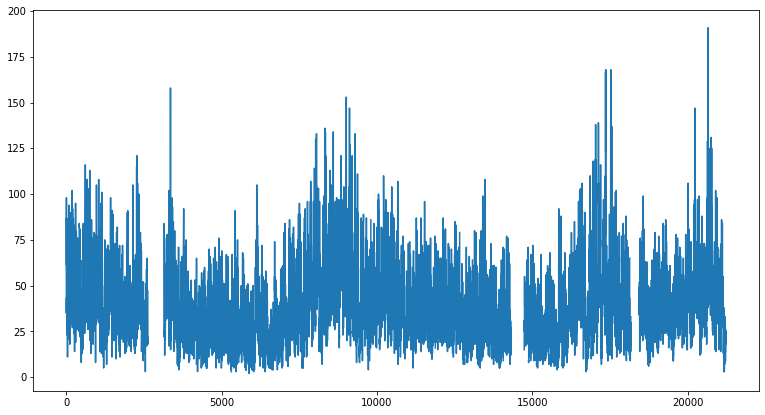

In [61]:
missDataDF[13].plot()

In [62]:
imputedDf = pd.DataFrame(imputed_data)

In [63]:
PM10_full

,ACO,AJM,ATI,BJU,CAM,CHO,CUA,CUT,FAC,HGM,...,PED,SAG,SFE,TAH,TLA,TLI,UIZ,VIF,XAL,GAM
2017-01-01 01:00:00,NaN,33.0,NaN,51.0,80.0,90.0,46.0,128.0,159.0,NaN,...,NaN,NaN,44.0,170.0,138.0,138.0,NaN,149.0,107.0,NaN
2017-01-01 02:00:00,NaN,37.0,NaN,71.0,100.0,87.0,56.0,154.0,104.0,NaN,...,NaN,NaN,30.0,190.0,100.0,165.0,NaN,199.0,221.0,NaN
2017-01-01 03:00:00,190.0,38.0,NaN,83.0,89.0,76.0,49.0,147.0,97.0,NaN,...,NaN,NaN,24.0,175.0,66.0,121.0,NaN,230.0,401.0,NaN
2017-01-01 04:00:00,230.0,38.0,NaN,111.0,103.0,69.0,57.0,147.0,92.0,NaN,...,NaN,NaN,34.0,126.0,68.0,181.0,NaN,364.0,252.0,NaN
2017-01-01 05:00:00,192.0,30.0,NaN,124.0,148.0,176.0,40.0,154.0,91.0,NaN,...,NaN,NaN,35.0,150.0,68.0,214.0,NaN,445.0,247.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 20:00:00,71.0,NaN,52.0,38.0,69.0,62.0,48.0,165.0,69.0,NaN,...,45.0,75.0,40.0,80.0,61.0,80.0,52.0,98.0,NaN,NaN
2021-12-31 21:00:00,77.0,NaN,63.0,39.0,23.0,57.0,47.0,133.0,72.0,NaN,...,43.0,55.0,32.0,98.0,71.0,79.0,56.0,106.0,NaN,NaN
2021-12-31 22:00:00,85.0,NaN,64.0,45.0,37.0,50.0,42.0,188.0,63.0,NaN,...,56.0,54.0,36.0,100.0,77.0,127.0,66.0,105.0,NaN,NaN
2021-12-31 23:00:00,98.0,NaN,75.0,51.0,36.0,53.0,53.0,202.0,69.0,NaN,...,64.0,68.0,47.0,135.0,83.0,169.0,74.0,110.0,NaN,NaN


In [64]:
imputedDf.columns = PM10_full.columns
imputedDf.index = PM10_full.index

In [71]:
imputedDf.columns

Index(['ACO', 'AJM', 'ATI', 'BJU', 'CAM', 'CHO', 'CUA', 'CUT', 'FAC', 'HGM',
       'INN', 'IZT', 'MER', 'MGH', 'MPA', 'PED', 'SAG', 'SFE', 'TAH', 'TLA',
       'TLI', 'UIZ', 'VIF', 'XAL', 'GAM'],
      dtype='object')

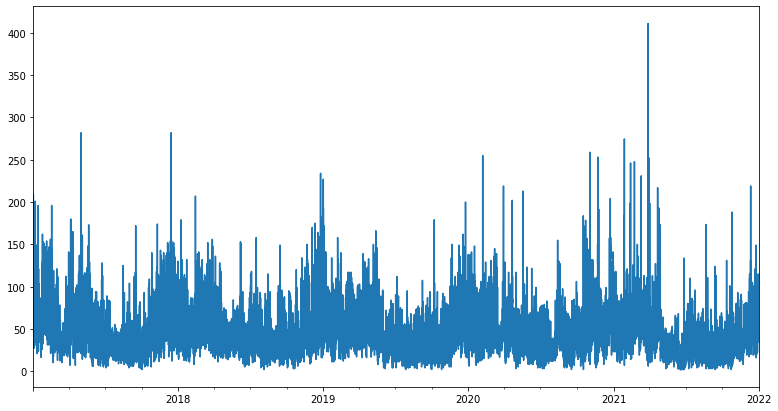

In [72]:
imputedDf['MER'].plot()

In [73]:
ori_dataDF = pd.DataFrame(ori_data)

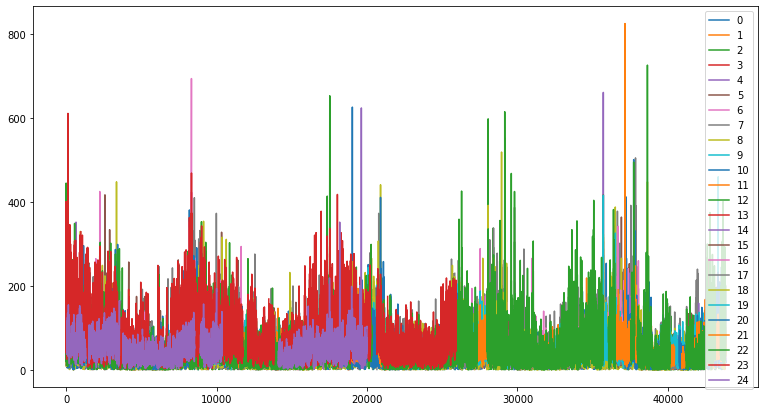

In [74]:
ori_dataDF.plot()

In [ ]:
#eda ordenarlo bien
#comparar el conjunto simulado contra el original
#actualizar el 2021
#que estaciones tienen mas datos 

In [75]:
dfsWithOnlyContaminants = []

for df in newDfs:
  elements_to_drop = [elemento for elemento in df.columns if elemento not in ['O3', 'NO2', 'SO2', 'CO', 'PM10', 'PM25']]
  dfWithOnlyContaminants = df.drop(columns=elements_to_drop)
  dfWithOnlyContaminants.name = df.name
  dfsWithOnlyContaminants.append(dfWithOnlyContaminants)

In [76]:
len(dfsWithOnlyContaminants)

35

In [77]:
#Estadística básica para cada estación

newDfs[1].describe()

,NO,PMCO,SO2,PM25,O3,NO2,PM10,NOX,CO,WSP,TMP,WDR,RH,PA
count,28186.000000,24087.000000,28141.000000,24087.000000,25845.000000,28186.000000,24087.000000,28186.000000,28403.000000,35702.000000,28908.000000,35702.000000,29543.000000,38533.000000
mean,4.021819,14.219704,3.122668,19.228754,40.346257,16.020897,33.444389,20.053963,0.312513,2.791320,16.124837,178.585177,51.646651,560.072743
std,6.410624,10.017330,5.408693,12.209490,25.018551,9.005773,19.378528,13.490376,0.204759,1.541237,3.852135,110.803187,20.407124,1.358498
min,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.100000,0.000000,2.000000,553.400000
25%,1.000000,7.000000,1.000000,10.000000,21.000000,9.000000,19.000000,10.250000,0.200000,1.700000,13.500000,60.000000,35.000000,559.000000
50%,2.000000,12.000000,1.000000,17.000000,35.000000,14.000000,30.000000,17.000000,0.300000,2.500000,15.700000,196.000000,51.000000,560.000000
75%,4.000000,20.000000,3.000000,25.000000,54.000000,21.000000,45.000000,26.000000,0.400000,3.500000,18.800000,259.000000,69.000000,561.000000
max,81.000000,175.000000,93.000000,117.000000,178.000000,86.000000,205.000000,132.000000,1.900000,14.600000,27.900000,360.000000,101.000000,565.000000


Text(0.5, 1.0, 'CO para la estación AJM')

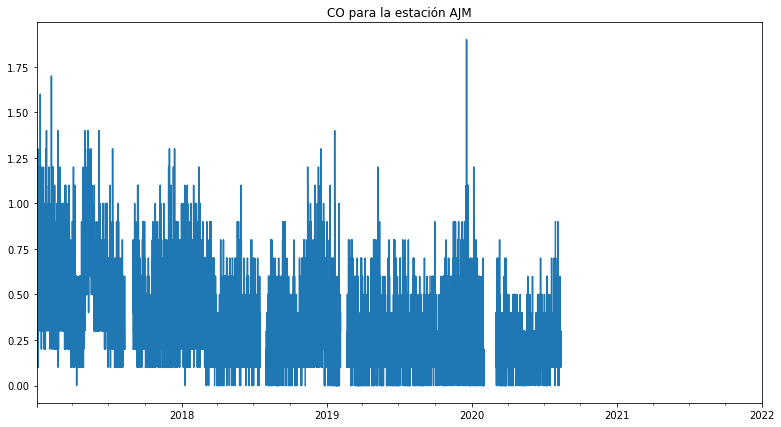

In [78]:
AJM = newDfs[1]

AJM['CO'].plot().set_title('CO para la estación AJM')

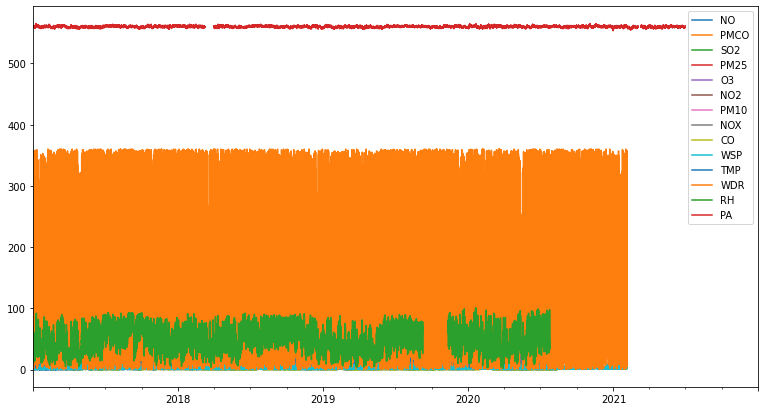

In [79]:
#Gráfica de una contaminante en una estación

newDfs[1].loc['2017': '2021'].plot()

In [80]:
ACO = newDfs[0]

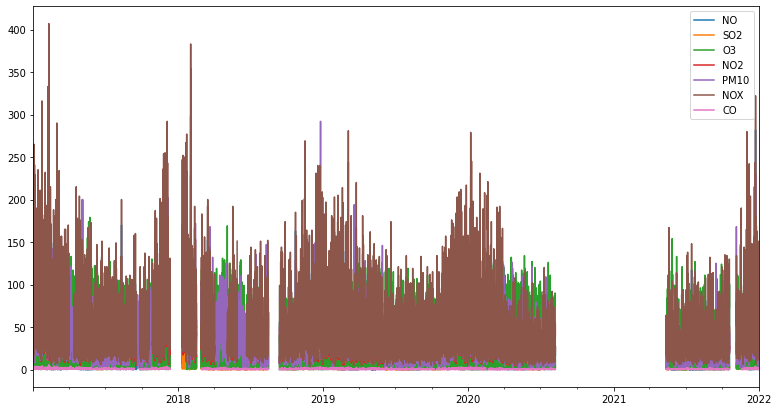

In [81]:
newDfs[12].plot()

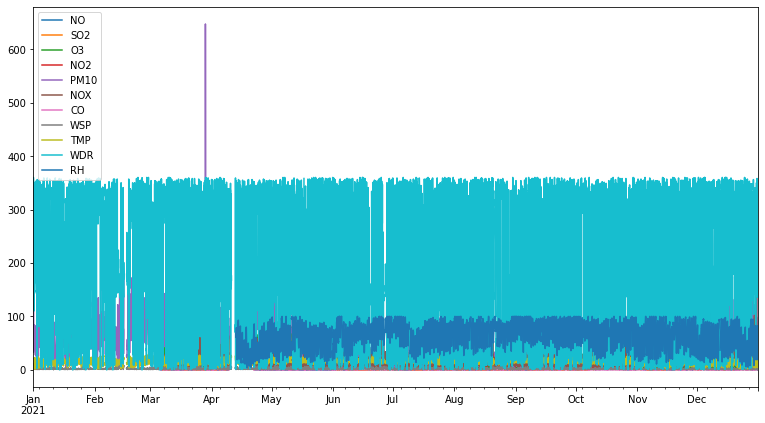

In [82]:
#Gráfica de todas las variables de una estación

ACO.loc['2021'].plot()

Text(0.5, 1.0, 'Estación ACO')

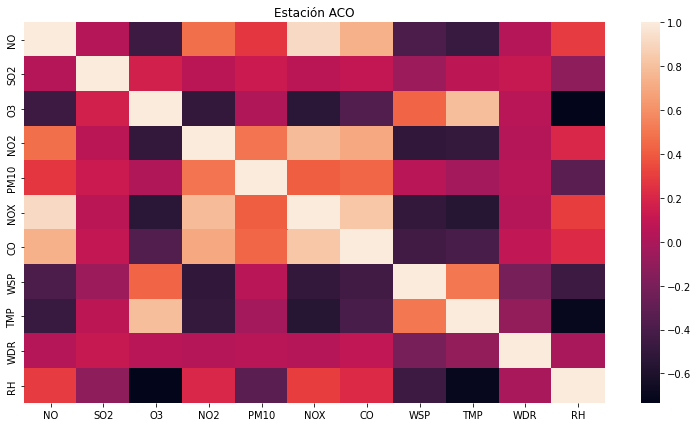

In [83]:
#Mapa de calor de correlacion de las variables en una estación

import seaborn as sns

corr = ACO.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values).set_title('Estación ACO')




In [84]:
newDfsOfVariables = []

myNewDf = pd.DataFrame(index = newDfs[0].index)

for variable in columns: 
  myNewDf = pd.DataFrame(index = newDfs[0].index)
  for df in newDfs:
    if variable in df:
      name = df.name 
      myNewDf[name] = df[variable]
  myNewDf.name = variable
  # myNewDf.to_csv(f"2017-2021{myNewDf.name}.csv")
  newDfsOfVariables.append(myNewDf)




In [85]:
CO = newDfsOfVariables[6]

In [87]:
for df in newDfsOfVariables:
  print(df.name)

NO
SO2
O3
NO2
PM10
NOX
CO
WSP
TMP
WDR
RH
PMCO
PM25
PA
UVB
UVA


In [88]:
PMCO = newDfsOfVariables[11]

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0.5, 1.0, 'PMCO')

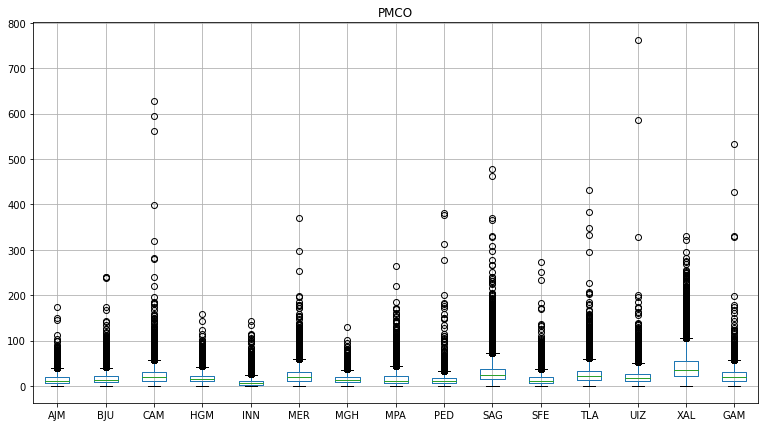

In [89]:
PMCO.boxplot().set_title('PMCO')

In [90]:
CO.name

'CO'

Text(0.5, 1.0, 'CO')

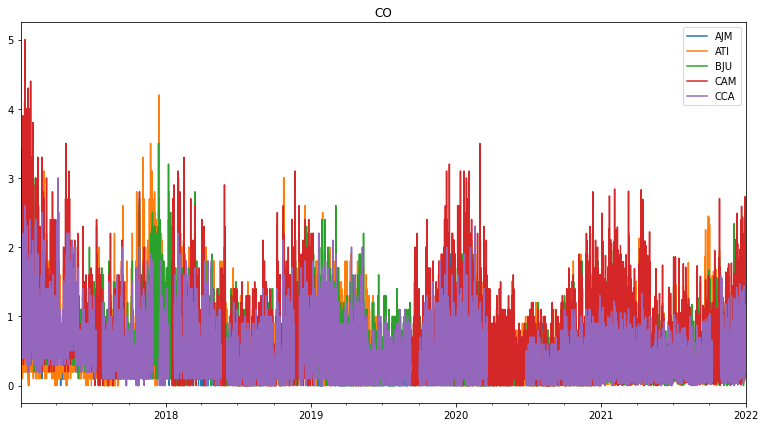

In [91]:
#Serie de tiempo del CO en dos o más estaciones

# CO[['ACO', 'AJM']].loc['2017'].plot()
pl = CO.iloc[:,1:6].plot()
pl.set_title('CO')

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


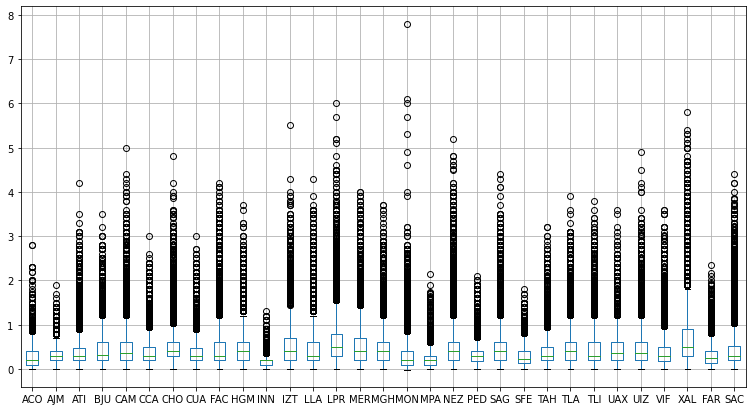

In [92]:
CO.boxplot()

In [93]:
listaDF = []

for df in newDfsOfVariables:
  if df.name in ['O3', 'NO2', 'SO2', 'CO', 'PM10', 'PM25']:
    listaDF.append(df)

In [94]:
len(listaDF)

6

In [95]:
monthlyCOUNT = listaDF[1].resample('M').count()

In [96]:
monthlyCOUNT

,ACO,AJM,ATI,BJU,CAM,CCA,CHO,CUA,CUT,FAC,...,TLA,TLI,UAX,UIZ,VIF,XAL,AJU,GAM,FAR,SAC
2017-01-31,422,726,701,703,706,688,723,726,721,717,...,668,725,716,721,381,689,717,588,0,0
2017-02-28,492,639,631,594,639,623,647,648,646,637,...,0,635,647,614,492,639,613,602,0,0
2017-03-31,707,711,720,707,643,722,714,712,711,718,...,464,712,692,0,712,712,683,676,709,711
2017-04-30,641,698,630,691,304,688,698,632,684,594,...,694,682,582,670,697,702,700,698,693,596
2017-05-31,674,709,680,615,721,726,715,725,630,707,...,724,695,723,560,700,726,550,719,705,708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-30,678,0,670,684,699,698,692,697,690,699,...,646,693,697,643,653,0,684,658,0,0
2021-10-31,691,0,579,733,716,231,637,721,701,712,...,702,667,713,634,719,0,696,710,0,0
2021-11-30,697,0,164,689,696,604,689,704,267,659,...,691,702,635,634,698,0,491,588,0,0
2021-12-31,682,0,712,683,722,726,723,712,647,718,...,713,718,361,723,712,0,328,584,0,0


In [97]:
monthly = listaDF[1].isna().resample('M').sum()

In [98]:
monthly

,ACO,AJM,ATI,BJU,CAM,CCA,CHO,CUA,CUT,FAC,...,TLA,TLI,UAX,UIZ,VIF,XAL,AJU,GAM,FAR,SAC
2017-01-31,321,17,42,40,37,55,20,17,22,26,...,75,18,27,22,362,54,26,155,743,743
2017-02-28,180,33,41,78,33,49,25,24,26,35,...,672,37,25,58,180,33,59,70,672,672
2017-03-31,37,33,24,37,101,22,30,32,33,26,...,280,32,52,744,32,32,61,68,35,33
2017-04-30,79,22,90,29,416,32,22,88,36,126,...,26,38,138,50,23,18,20,22,27,124
2017-05-31,70,35,64,129,23,18,29,19,114,37,...,20,49,21,184,44,18,194,25,39,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-30,42,720,50,36,21,22,28,23,30,21,...,74,27,23,77,67,720,36,62,720,720
2021-10-31,53,744,165,11,28,513,107,23,43,32,...,42,77,31,110,25,744,48,34,744,744
2021-11-30,23,720,556,31,24,116,31,16,453,61,...,29,18,85,86,22,720,229,132,720,720
2021-12-31,62,744,32,61,22,18,21,32,97,26,...,31,26,383,21,32,744,416,160,744,744


In [99]:
for df in listaDF:
  print(df.name)

SO2
O3
NO2
PM10
CO
PM25


In [100]:
dfsWithPercentages = []


for df in listaDF:

  # monthly = listaDF[5].isna().resample('M').sum()
  # df2 = monthly.divide(listaDF[5].resample('M').size(), axis=0 ) * 100

  # df2.to_csv(f"Porcentaje_Datos_faltantes_{listaDF[5].name}.csv")
  
  monthly = df.isna().resample('M').sum()
  df2 = monthly.divide(df.resample('M').size(), axis=0 ) * 100

  df2.to_csv(f"Porcentaje_Datos_faltantes_{df.name}.csv")

  df2['Contaminante'] = df.name 
  column_to_move = df2.pop("Contaminante")
  df2.insert(0, "Contaminante", column_to_move)

  df2.reset_index(inplace=True)
  df2 = df2.rename(columns = {'index':'Fecha'})

  dfsWithPercentages.append(df2)

In [101]:
result = pd.concat(dfsWithPercentages)

In [154]:
result.to_csv(f"Porcentaje_Datos_faltantes_test.csv")

In [123]:
listaDF[5].name

'PM25'

In [104]:
df.reset_index(inplace=True)
df = df.rename(columns = {'index':'Fecha'})

In [105]:
df['Contaminant'] = listaDF[5].name
column_to_move = df.pop("Contaminant")

# insert column with insert(location, column_name, column_value)

df.insert(0, "Contaminant", column_to_move)

In [106]:
monthly2 = listaDF[4].isna().resample('M').sum()
df2 = monthly2.divide(listaDF[4].resample('M').size(), axis=0 ) * 100

In [107]:
listaDF[4].name

'CO'

In [108]:
df2.reset_index(inplace=True)
df2 = df2.rename(columns = {'index':'Fecha'})

In [109]:
df2['Contaminant'] = listaDF[4].name
column_to_move = df2.pop("Contaminant")

# insert column with insert(location, column_name, column_value)

df2.insert(0, "Contaminant", column_to_move)

In [110]:
df

,Contaminant,Fecha,AJM,BJU,CAM,CCA,HGM,INN,MER,MGH,...,SAG,SFE,TLA,UAX,UIZ,XAL,AJU,GAM,FAR,SAC
0,PM25,2017-01-01 01:00:00,23.0,40.0,57.0,50.0,NaN,13.0,46.0,37.0,...,NaN,33.0,95.0,82.0,NaN,70.0,NaN,NaN,NaN,NaN
1,PM25,2017-01-01 02:00:00,26.0,58.0,74.0,48.0,NaN,12.0,73.0,30.0,...,NaN,22.0,68.0,103.0,NaN,159.0,NaN,NaN,NaN,NaN
2,PM25,2017-01-01 03:00:00,27.0,71.0,66.0,60.0,NaN,10.0,74.0,49.0,...,NaN,18.0,42.0,112.0,NaN,175.0,21.0,NaN,NaN,NaN
3,PM25,2017-01-01 04:00:00,27.0,94.0,77.0,68.0,NaN,11.0,84.0,77.0,...,NaN,27.0,45.0,104.0,NaN,165.0,13.0,NaN,NaN,NaN
4,PM25,2017-01-01 05:00:00,21.0,103.0,108.0,71.0,NaN,10.0,100.0,87.0,...,NaN,27.0,48.0,112.0,NaN,177.0,14.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,PM25,2021-12-31 20:00:00,NaN,16.0,33.0,18.0,NaN,11.0,23.0,NaN,...,36.0,22.0,18.0,NaN,19.0,NaN,19.0,NaN,NaN,NaN
43820,PM25,2021-12-31 21:00:00,NaN,21.0,16.0,20.0,NaN,11.0,25.0,NaN,...,31.0,17.0,28.0,NaN,28.0,NaN,19.0,NaN,NaN,NaN
43821,PM25,2021-12-31 22:00:00,NaN,27.0,24.0,24.0,NaN,10.0,33.0,NaN,...,33.0,23.0,35.0,NaN,37.0,NaN,40.0,NaN,NaN,NaN
43822,PM25,2021-12-31 23:00:00,NaN,33.0,28.0,30.0,NaN,14.0,35.0,NaN,...,41.0,31.0,40.0,NaN,44.0,NaN,60.0,NaN,NaN,NaN


In [111]:
df2

,Contaminant,Fecha,ACO,AJM,ATI,BJU,CAM,CCA,CHO,CUA,...,SFE,TAH,TLA,TLI,UAX,UIZ,VIF,XAL,FAR,SAC
0,CO,2017-01-31,4.576043,2.691790,6.056528,8.075370,5.652759,6.998654,21.399731,4.037685,...,8.209960,3.903096,11.843876,9.959623,3.903096,3.499327,100.000000,5.248991,100.0,100.000000
1,CO,2017-02-28,3.720238,5.059524,20.833333,7.738095,3.125000,7.142857,3.571429,3.422619,...,8.928571,3.571429,62.797619,5.357143,3.720238,7.291667,26.785714,4.315476,100.0,100.000000
2,CO,2017-03-31,3.897849,4.301075,3.763441,4.704301,16.935484,2.822581,5.107527,4.704301,...,100.000000,68.279570,13.172043,3.360215,2.822581,99.865591,2.822581,5.913978,100.0,3.897849
3,CO,2017-04-30,51.666667,5.555556,3.055556,99.861111,58.333333,5.138889,2.500000,12.916667,...,25.416667,45.416667,3.750000,22.361111,23.333333,6.944444,3.194444,2.500000,100.0,3.888889
4,CO,2017-05-31,15.322581,10.752688,8.602151,45.564516,9.274194,2.553763,6.854839,2.688172,...,4.166667,13.844086,4.166667,8.736559,2.956989,24.865591,5.913978,2.822581,100.0,4.435484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,CO,2021-09-30,5.833333,100.000000,7.083333,5.277778,2.916667,3.055556,4.166667,3.750000,...,34.166667,29.305556,5.694444,3.611111,3.194444,10.555556,20.138889,100.000000,100.0,100.000000
57,CO,2021-10-31,6.451613,100.000000,22.177419,1.478495,3.763441,67.741935,6.989247,3.091398,...,4.704301,22.849462,4.166667,9.946237,3.897849,14.919355,3.360215,100.000000,100.0,100.000000
58,CO,2021-11-30,3.194444,100.000000,77.222222,4.305556,3.333333,9.444444,4.444444,2.222222,...,31.944444,5.555556,3.611111,2.500000,7.083333,11.944444,14.027778,100.000000,100.0,100.000000
59,CO,2021-12-31,4.704301,100.000000,3.494624,7.930108,2.553763,2.150538,2.822581,4.032258,...,4.704301,5.510753,4.838710,3.225806,48.252688,3.897849,5.779570,100.000000,100.0,100.000000


In [112]:

# concatenating df1 and df2 along rows
vertical_concat = pd.concat([df, df2], axis=0)

In [113]:
vertical_concat

,Contaminant,Fecha,AJM,BJU,CAM,CCA,HGM,INN,MER,MGH,...,ATI,CHO,CUA,FAC,IZT,LLA,LPR,TAH,TLI,VIF
0,PM25,2017-01-01 01:00:00,23.0,40.000000,57.000000,50.000000,NaN,13.000000,46.000000,37.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PM25,2017-01-01 02:00:00,26.0,58.000000,74.000000,48.000000,NaN,12.000000,73.000000,30.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PM25,2017-01-01 03:00:00,27.0,71.000000,66.000000,60.000000,NaN,10.000000,74.000000,49.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PM25,2017-01-01 04:00:00,27.0,94.000000,77.000000,68.000000,NaN,11.000000,84.000000,77.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PM25,2017-01-01 05:00:00,21.0,103.000000,108.000000,71.000000,NaN,10.000000,100.000000,87.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,CO,2021-09-30 00:00:00,100.0,5.277778,2.916667,3.055556,100.0,32.638889,2.222222,2.638889,...,7.083333,4.166667,3.750000,2.916667,4.444444,100.0,2.777778,29.305556,3.611111,20.138889
57,CO,2021-10-31 00:00:00,100.0,1.478495,3.763441,67.741935,100.0,73.655914,5.107527,2.419355,...,22.177419,6.989247,3.091398,4.301075,39.919355,100.0,2.419355,22.849462,9.946237,3.360215
58,CO,2021-11-30 00:00:00,100.0,4.305556,3.333333,9.444444,100.0,4.861111,2.638889,9.027778,...,77.222222,4.444444,2.222222,3.055556,61.250000,100.0,6.111111,5.555556,2.500000,14.027778
59,CO,2021-12-31 00:00:00,100.0,7.930108,2.553763,2.150538,100.0,8.736559,4.166667,3.629032,...,3.494624,2.822581,4.032258,3.494624,5.241935,100.0,3.360215,5.510753,3.225806,5.779570


In [114]:
vertical_concat.groupby([ 'Fecha', 'Contaminant'])['AJM'].value_counts(normalize = True).mul(100).round(2).unstack(0).reset_index()

Fecha,Contaminant,AJM,2017-01-01 01:00:00,2017-01-01 02:00:00,2017-01-01 03:00:00,2017-01-01 04:00:00,2017-01-01 05:00:00,2017-01-01 06:00:00,2017-01-01 07:00:00,2017-01-01 08:00:00,...,2021-04-30 00:00:00,2021-05-31 00:00:00,2021-06-30 00:00:00,2021-07-31 00:00:00,2021-08-31 00:00:00,2021-09-30 00:00:00,2021-10-31 00:00:00,2021-11-30 00:00:00,2021-12-31 00:00:00,2022-01-31 00:00:00
0,CO,2.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CO,2.150538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CO,2.419355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CO,2.553763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CO,2.638889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,PM25,105.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,PM25,106.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135,PM25,107.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136,PM25,109.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


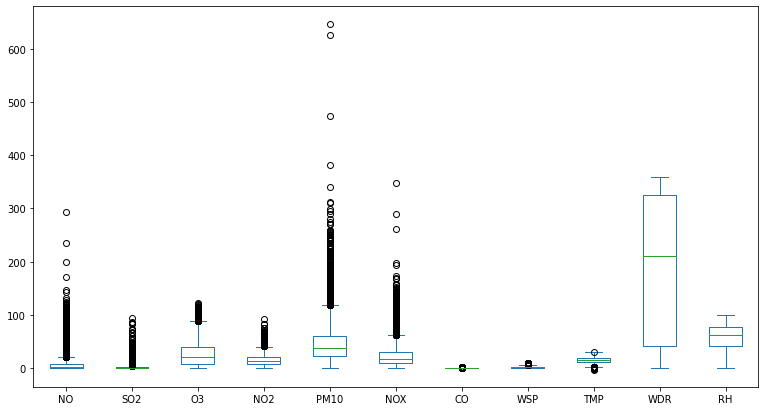

In [115]:
import seaborn as sns

ACO.plot.box()

In [ ]:
#grafica para ver distribucion (de campana)

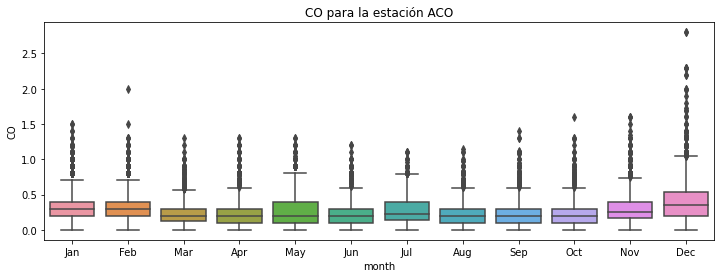

In [116]:
ACO['month'] = ACO.index.to_series().dt.strftime('%b')
fig, ax = plt.subplots()
fig.set_size_inches((12,4))
sns.boxplot(x='month',y='CO',data=ACO,ax=ax).set_title('CO para la estación ACO')
plt.show()

In [117]:
def concentracionPromedio12Horas(estacion, fecha_a_calcular, contaminante):
  fecha_a_calcular_dt = datetime.strptime(fecha_a_calcular, "%Y-%m-%d %H:%M:%S")
  first_date = fecha_a_calcular_dt - timedelta(hours = 11)
  first_date_string = first_date.strftime("%Y-%m-%d %H:%M:%S")

  horas = estacion[contaminante].loc[first_date_string: fecha_a_calcular]

  minus3Hours = fecha_a_calcular_dt - timedelta(hours = 2)
  minus3Hours_string = minus3Hours.strftime("%Y-%m-%d %H:%M:%S")

  horasPorEvaluar = horas.loc[minus3Hours_string:fecha_a_calcular]

  if(horasPorEvaluar.isna().sum() > 1):
    print('Necesitas por lo menos 2 concentraciones de las 3 horas recientes')
    return np.NaN

  C_max = horas.max()
  C_min = horas.min()
  Rango = C_max - C_min

  w = 1 - (Rango / C_max)

  if(w <= 0.5):
    W = 0.5
  else:
    W = w

  C_top = 0
  for idx,hora in enumerate(reversed(horas)):
    if isnan(hora):
      continue
    C_top = C_top + (hora*W**(idx))

  C_bottom = 0
  for idx in range(len(horas)):
    if isnan(hora):
      continue
    C_bottom = C_bottom + (W**(idx))

  C = C_top/C_bottom

  C_rounded = round(C, 0)
  return C_rounded

In [118]:
def concentracionPromedioMovil(estacion, fecha_a_calcular, numeroHoras, redondeo,  contaminante):

  fecha_a_calcular_dt = datetime.strptime(fecha_a_calcular, "%Y-%m-%d %H:%M:%S")
  first_date = fecha_a_calcular_dt - timedelta(hours = numeroHoras - 1)
  first_date_string = first_date.strftime("%Y-%m-%d %H:%M:%S")
  horas = estacion[contaminante].loc[first_date_string: fecha_a_calcular]

  if(numeroHoras == 1 and horas.isna().sum() == 1):
    print('No hay información suficiente para calcular el índice, para concentración promedio horaria se necesita el valor para realizar el cálculo.')
    return np.NaN
    # raise ValueError('No hay información suficiente para calcular el índice, para concentración promedio horaria se necesita el valor para realizar el cálculo.')
  if(numeroHoras == 8 and horas.isna().sum() > 2):
    print('No hay información suficiente para calcular el índice, para concentración promedio movil de 8 horas se necesitan por lo menos el 75% de las concentraciones promedio horaria.')
    return np.NaN
    # raise ValueError('No hay información suficiente para calcular el índice, para concentración promedio movil de 8 horas se necesitan por lo menos el 75% de las concentraciones promedio horaria.')
  if(numeroHoras == 24 and horas.isna().sum() > 6):
    print('No hay información suficiente para calcular el índice, para concentración promedio movil de 24 horas se necesitan por lo menos el 75% de las concentraciones promedio horaria.')
    return np.NaN
    # raise ValueError('No hay información suficiente para calcular el índice, para concentración promedio movil de 24 horas se necesitan por lo menos el 75% de las concentraciones promedio horaria.')
  if(contaminante != 'CO'):
    horas = horas * 0.001
  
  # cifras = redondeo - 2

  # horas.apply(lambda x: round(x, cifras - int(floor(log10(abs(x))))) if not isnan(x) else np.NaN)

  promedio = horas.mean()
  # print('sin redondear',promedio)
  return round(promedio,redondeo - 1)

In [119]:
from bisect import bisect
import math


def PM10(score, breakpoints=[75, 155, 235], grades= ['ACEPTABLE', 'MALA', 'MUY MALA', 'EXTREMADAMENTE MALA' ]):
    if(score <= 50):
      return 'BUENA'
    i = bisect(breakpoints, score)
    return grades[i]
def PM25(score, breakpoints=[45, 79, 147], grades= ['ACEPTABLE', 'MALA', 'MUY MALA', 'EXTREMADAMENTE MALA' ]):
    if(score <= 25):
      return 'BUENA'
    i = bisect(breakpoints, score)
    return grades[i]
def O3(score, breakpoints=[0.095, 0.135, 0.175], grades= ['ACEPTABLE', 'MALA', 'MUY MALA', 'EXTREMADAMENTE MALA' ]):
    if(score <= 0.051):
      return 'BUENA'
    i = bisect(breakpoints, score)
    return grades[i]
def O38H(score, breakpoints=[0.070, 0.092, 0.114], grades= ['ACEPTABLE', 'MALA', 'MUY MALA', 'EXTREMADAMENTE MALA' ]):
    if(score <= 0.051):
      return 'BUENA'
    i = bisect(breakpoints, score)
    return grades[i]
def NO2(score, breakpoints=[0.210, 0.230, 0.250], grades= ['ACEPTABLE', 'MALA', 'MUY MALA', 'EXTREMADAMENTE MALA' ]):
    if(score <= 0.107):
      return 'BUENA'
    i = bisect(breakpoints, score)
    return grades[i]
def SO2(score, breakpoints=[0.110, 0.165, 0.220], grades= ['ACEPTABLE', 'MALA', 'MUY MALA', 'EXTREMADAMENTE MALA' ]):
    if(score <= 0.008):
      return 'BUENA'
    i = bisect(breakpoints, score)
    return grades[i]
def CO(score, breakpoints=[11, 13.3, 15.5], grades= ['ACEPTABLE', 'MALA', 'MUY MALA', 'EXTREMADAMENTE MALA' ]):
    if(score <= 8.75):
      return 'BUENA'
    i = bisect(breakpoints, score)
    return grades[i]

[PM10(score) for score in [33, 50, 60, 100, 200, 300]]

['BUENA', 'BUENA', 'ACEPTABLE', 'MALA', 'MUY MALA', 'EXTREMADAMENTE MALA']

In [121]:
from datetime import datetime, timedelta
from math import isnan
def calcularIndices(estacion, fecha_a_calcular):
  for column in estacion.columns:
    if(column == 'SO2'):
      concentracion_base = concentracionPromedioMovil(estacion, fecha_a_calcular, 24, 4,column)
      print(column, concentracion_base)
      if(not isnan(concentracion_base)):
        print('indice: ', SO2(concentracion_base))
    elif(column == 'CO'):
      concentracion_base = concentracionPromedioMovil(estacion, fecha_a_calcular, 8, 3,column)
      print(column, concentracion_base)
      if(not isnan(concentracion_base)):
        print('indice: ', CO(concentracion_base))
    elif (column == 'PM25'):
      concentracion_base = concentracionPromedio12Horas(estacion,fecha_a_calcular, column)
      print(column, concentracion_base)
      if(not isnan(concentracion_base)):
        print('indice: ', PM25(concentracion_base))
    elif(column == 'O3'):
      concentracion_base = concentracionPromedioMovil(estacion, fecha_a_calcular, 8, 4,column)
      concentracion_base2 = concentracionPromedioMovil(estacion, fecha_a_calcular, 1, 4,column)
      print(column+' 8h', concentracion_base)
      print(column, concentracion_base2)
      if(not isnan(concentracion_base)):
        print('indice: ', O38H(concentracion_base))
      if(not isnan(concentracion_base2)):
        print('indice: ', O3(concentracion_base))
    elif(column == 'NO2'):
      concentracion_base = concentracionPromedioMovil(estacion, fecha_a_calcular, 1, 4,column)
      print(column,concentracion_base)
      if(not isnan(concentracion_base)):
        print('indice: ', NO2(concentracion_base))
    elif(column == 'PM10'):
      concentracion_base = concentracionPromedio12Horas(estacion,fecha_a_calcular, column)
      print(column, concentracion_base)
      if(not isnan(concentracion_base)):
        print('indice: ', PM10(concentracion_base))
    
# calcularIndices(estacion3,'2021-04-22 17:00:00')
calcularIndices(estacion,'2021-01-19 13:00:00')




NameError: ignored

In [122]:
from math import floor, log10, isnan

horas.apply(lambda x: round(x, 2 - int(floor(log10(abs(x))))) if not isnan(x) else np.NaN)

NameError: ignored